<center> <h1> Jump metadata compound filtering into an unbiased dataset relative to source, microscope configuration and well. </h1> </center>

In [1140]:
import polars as pl
from data_v2 import get_table
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# 1) Data Loading and Merging

In [1141]:
compound = get_table("compound")
well = get_table("well")
plate = get_table("plate")
micro = get_table("microscope_config")
moa = get_table("moa")

* Plate Metadata_source is not necessarily useful for the merging as it is not a unique identifiers. 
* For moa dataset, Only the InChIKey and the moa colums are really useful. Also, let's be careful and remove all compounds which are undefined and moa as well from this table. 

In [1142]:
plate = plate.select(pl.all().exclude("Metadata_Source"))

moa = moa.select(
    pl.col("InChIKey", "moa")).filter(
    (pl.col("InChIKey")!="NA") & (pl.col("moa")!="NA"))

* For the micro dataset, a certain subset of columns are important. 

In [1143]:
micro_features = ['Metadata_Source','Metadata_Microscope_Name',
                  'Metadata_Widefield_vs_Confocal',
                  'Metadata_Excitation_Type',
                  'Metadata_Objective_NA',
                  'Metadata_Filter_Configuration']
micro = micro.with_columns(
    ("source_" + pl.col("Metadata_Source").cast(str)).alias("Metadata_Source")).select(
    pl.col(micro_features))

In [1144]:
merge_table = compound.join(well, on=pl.col("Metadata_JCP2022"), how="inner")\
.join(plate, on=pl.col("Metadata_Plate"), how="inner")\
.join(micro, on=pl.col("Metadata_Source"), how="inner")\
.join(moa,left_on=pl.col("Metadata_InChIKey"), right_on=pl.col("InChIKey"), how="left")

# 2) Data Preprocessing
The goal here is to remove any odds data that we cannot work with.
1. Data with no InChIKey are cells untreated wich may not mean anything. Those are identified with a having the following shape: JCP2022_99...
2. Source 7 is the same as Source 13.
3. Data with uncomparable wells identifiers. 

In [1145]:
# Remove the JCP2022_99... sample. 
filter_merge_table = merge_table.filter(pl.col("Metadata_JCP2022").str.contains("JCP2022_99+") != True)

In [1146]:
# Rename the source 13 into source 7
filter_merge_table = filter_merge_table.with_columns(
    pl.when(pl.col("Metadata_Source").str.contains("_13$"))
    .then(pl.lit("source_7"))
    .otherwise(pl.col("Metadata_Source"))
    .alias("Metadata_Source"))

In [1147]:
# Let's check if there is any abnormality with the unique value observed for each features. 
filter_merge_table.select(pl.all().n_unique())

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,moa
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
115795,115795,115795,11,2337,1536,143,8,5,2,2,3,7,46


### There should only be 384 different well. 

In [1148]:
filter_merge_table.select(pl.col("Metadata_Well")).unique()

Metadata_Well
str
"""D15"""
"""H17"""
"""X04"""
"""AA18"""
"""Z14"""
"""H47"""
"""G31"""
"""D38"""
"""U17"""


### We can notice that some Wells has a double letter identification. Let's remove them.

In [1149]:
filter_merge_table.select(pl.col("Metadata_Well"), 
                          pl.col("Metadata_Source")).group_by("Metadata_Source").n_unique()

Metadata_Source,Metadata_Well
str,u32
"""source_3""",384
"""source_8""",384
"""source_9""",1536
"""source_6""",384
"""source_5""",384
"""source_1""",1472
"""source_7""",384
"""source_4""",384
"""source_2""",384


### Let's Remove source_9 and source_1.

In [1150]:
filter_merge_table = filter_merge_table.filter(pl.col("Metadata_Source").str.contains("_9|_1$") != True)

In [1151]:
filter_merge_table.select(pl.all().n_unique())

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,moa
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
115784,115784,115784,9,2174,384,126,8,5,2,2,2,6,46


Now let's create let's create a unique identifiers for each combination microscope features per sources as the combination of features may be the same in certain source.

In [1152]:
micro = micro.filter(pl.col("Metadata_Source").str.contains("_[19]$|_15$|_13$") != True)
map_micro_ID = micro.select(pl.col("Metadata_Source"),
                            pl.struct(pl.all().exclude("Metadata_Source")).alias("unique"))\
                            .sort(by="unique")\
                            .select(pl.col("Metadata_Source"), pl.col("unique").rle_id().alias("Micro_id"))

map_micro_ID

Metadata_Source,Micro_id
str,u32
"""source_7""",0
"""source_6""",1
"""source_10""",1
"""source_5""",2
"""source_2""",3
"""source_8""",4
"""source_3""",5
"""source_4""",5
"""source_11""",6


In [1153]:
filter_merge_table = filter_merge_table.join(map_micro_ID, on=pl.col("Metadata_Source"), how="left")

In [1154]:
filter_merge_table.select(pl.all().n_unique())

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,moa,Micro_id
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
115784,115784,115784,9,2174,384,126,8,5,2,2,2,6,46,7


# 3) Visualization

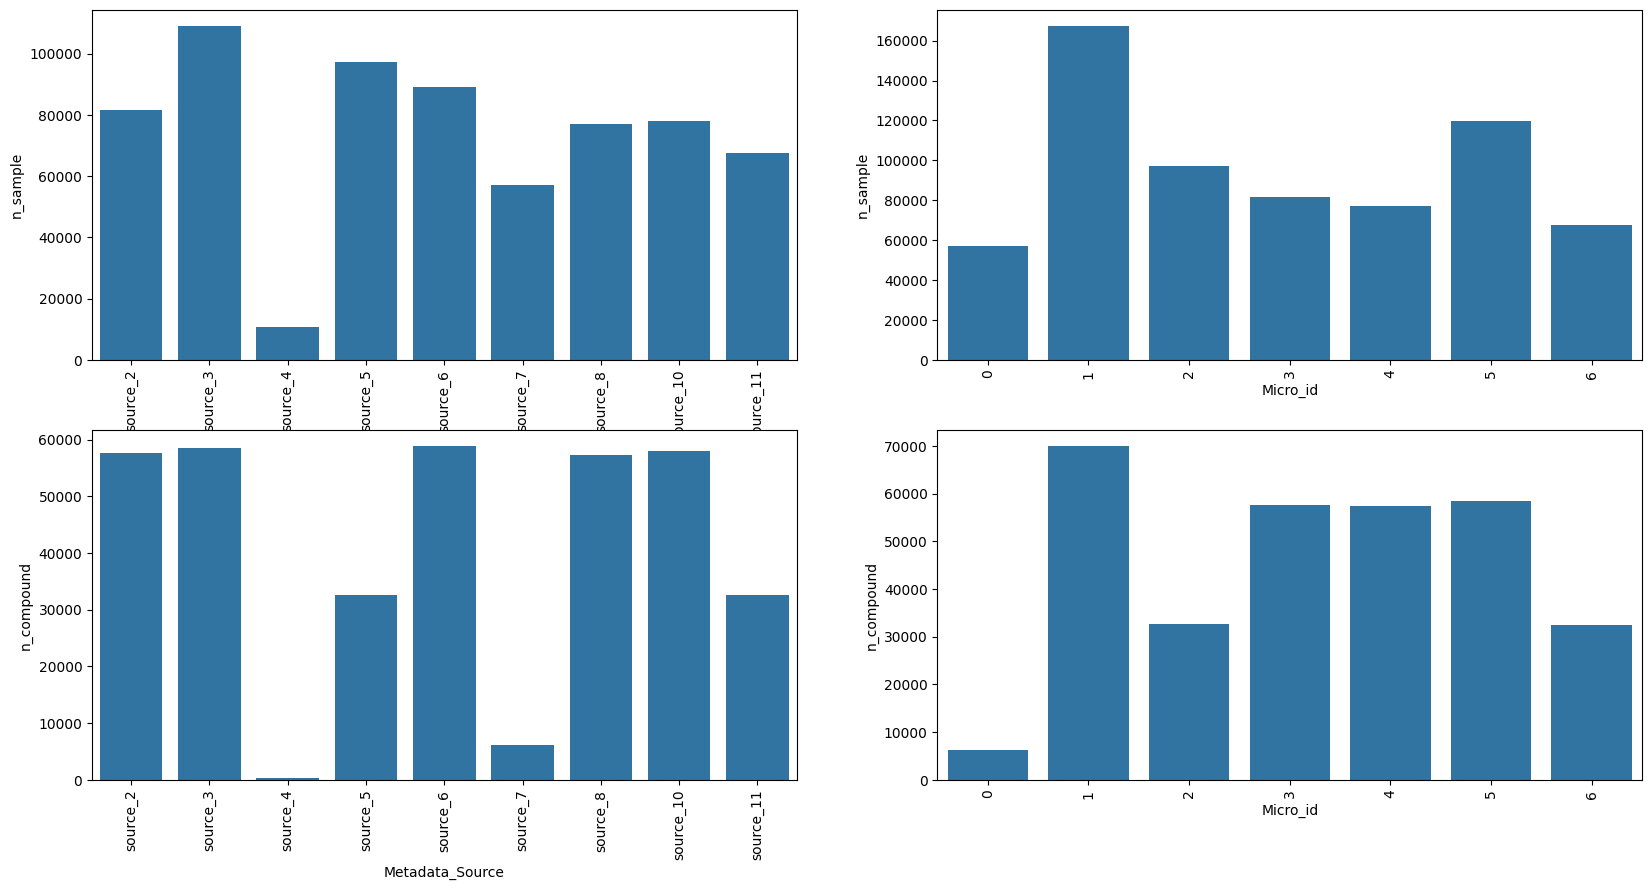

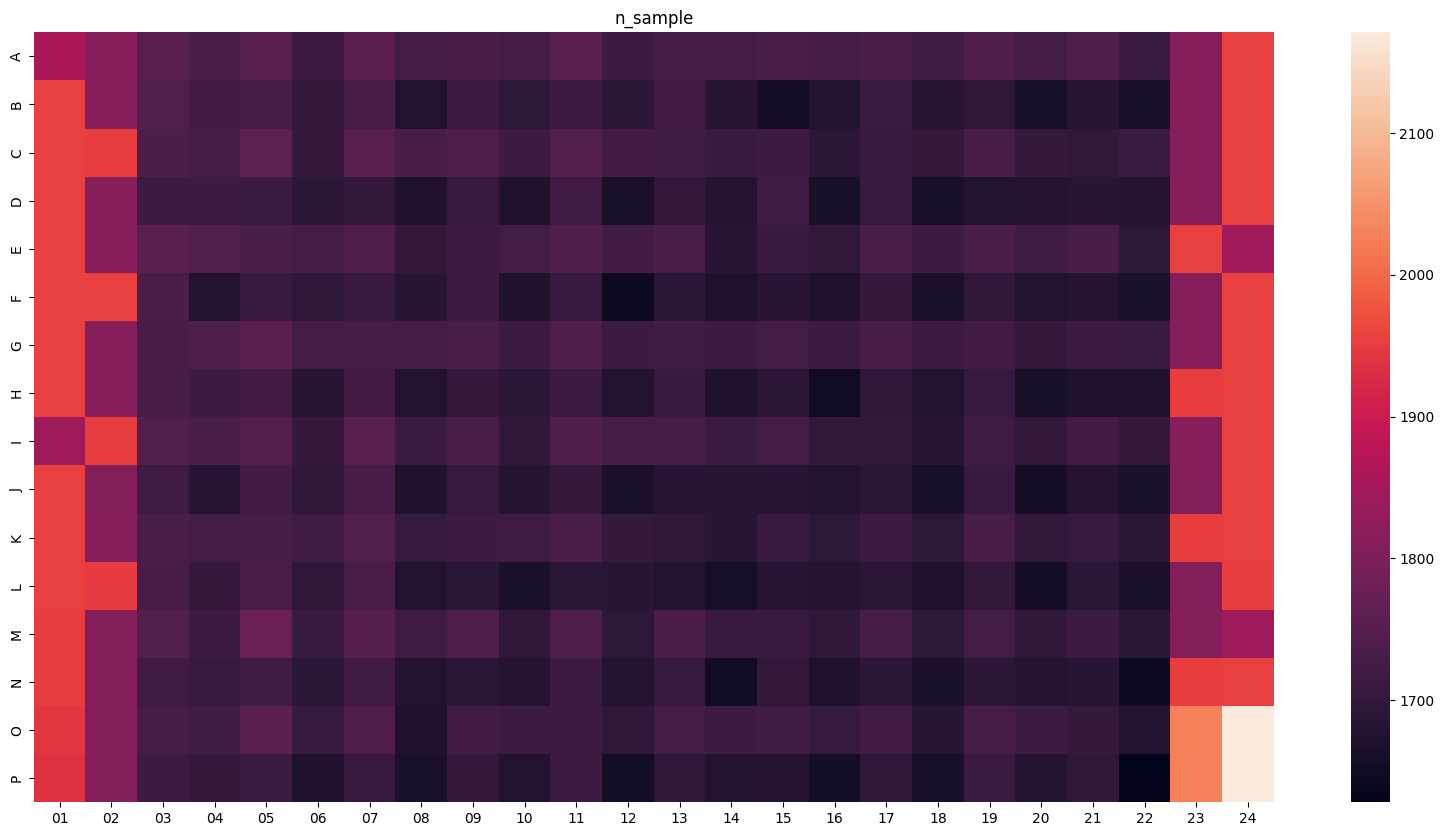

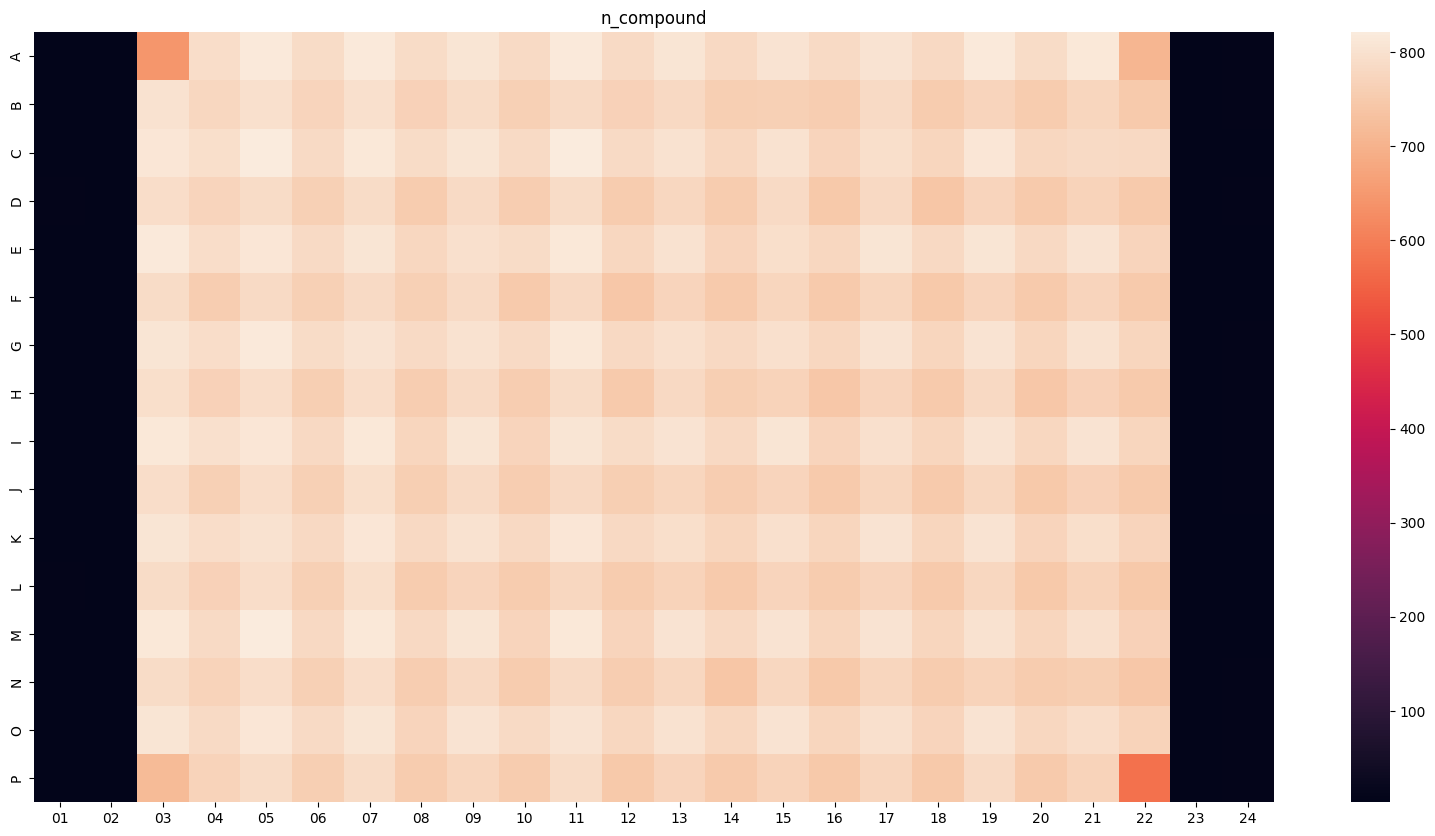

In [1155]:
def show_distribution(filter_merge_table):
    info_per_source = (filter_merge_table.group_by("Metadata_Source")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by=pl.col("Metadata_Source").str.extract("\D+_(\d+)").cast(pl.Int16)))
     
    info_per_micro = (filter_merge_table.group_by("Micro_id")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by="Micro_id"))
    
    info_per_well = (filter_merge_table.group_by("Metadata_Well")
                         .agg(
                             pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                             pl.col("Metadata_JCP2022").count().alias("n_sample"))
                       .sort(by="Metadata_Well"))

    info_per_well = (filter_merge_table.group_by("Metadata_Well")
                     .agg(
                         pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
                         pl.col("Metadata_JCP2022").count().alias("n_sample"))
                   .sort(by="Metadata_Well").select(
                       pl.col("Metadata_Well").str.extract("(\D+)").alias("Well_letter"),
                       pl.col("Metadata_Well").str.extract("\D+(\d+)").alias("Well_numb"),
                       pl.col("n_compound", "n_sample")))

    
    fig, axes = plt.subplots(2,2, figsize=(20, 10))
    info_per_group = [info_per_source, info_per_micro]
    group = ["Metadata_Source", "Micro_id"]
    info = ["n_sample", "n_compound"]
    for i in range(2):
        for j in range(2):
            sns.barplot(info_per_group[j],
                       x=group[j],
                       y=info[i],
                       ax=axes[i][j])
            axes[i][j].tick_params(axis='x', rotation=90)


    sample_well_map = info_per_well.pivot(index="Well_letter",
                                    columns="Well_numb",
                                    values="n_sample")
    compound_well_map = info_per_well.pivot(index="Well_letter",
                                    columns="Well_numb",
                                    values="n_compound")
    
    
    fig2, ax2 = plt.subplots(1, figsize=(20,10))
    sns.heatmap(sample_well_map.select(pl.all().exclude("Well_letter")),
                ax=ax2)
    ax2.set_xticklabels(sample_well_map.columns[1:])
    ax2.set_yticklabels(sample_well_map.select(pl.col("Well_letter")).to_numpy().reshape(-1))
    ax2.set_title("n_sample")

    
    fig3, ax3 = plt.subplots(1, figsize=(20,10))
    sns.heatmap(compound_well_map.select(pl.all().exclude("Well_letter")),
                ax=ax3)
    ax3.set_xticklabels(compound_well_map.columns[1:])
    ax3.set_yticklabels(compound_well_map.select(pl.col("Well_letter")).to_numpy().reshape(-1))
    ax3.set_title("n_compound")
show_distribution(filter_merge_table)

In [1156]:
compounds_info = (filter_merge_table.group_by("Metadata_JCP2022")
                  .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                       pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                       .n_unique().name.prefix("Unique_"))
                       )
compounds_info

Metadata_JCP2022,Sample_count,Unique_Metadata_Source,Unique_Metadata_Well,Unique_Micro_id
str,u32,u32,u32,u32
"""JCP2022_012356…",3,3,2,2
"""JCP2022_040199…",4,4,2,4
"""JCP2022_051101…",4,4,2,3
"""JCP2022_045368…",3,3,2,2
"""JCP2022_060087…",4,2,1,2
"""JCP2022_059101…",4,4,2,3
"""JCP2022_035930…",4,4,2,3
"""JCP2022_000470…",3,3,2,2
"""JCP2022_001842…",3,3,2,2


In [1157]:
compounds_info.select(pl.all().exclude("Metadata_JCP2022")).corr()

Sample_count,Unique_Metadata_Source,Unique_Metadata_Well,Unique_Micro_id
f64,f64,f64,f64
1.0,0.035047,0.874005,0.02921
0.035047,1.0,0.290962,0.870961
0.874005,0.290962,1.0,0.308716
0.02921,0.870961,0.308716,1.0


(<matplotlib.patches.Rectangle at 0x7f2346f2ff70>,
 (<matplotlib.patches.ConnectionPatch at 0x7f2353b28220>,
  <matplotlib.patches.ConnectionPatch at 0x7f2353b88cd0>))

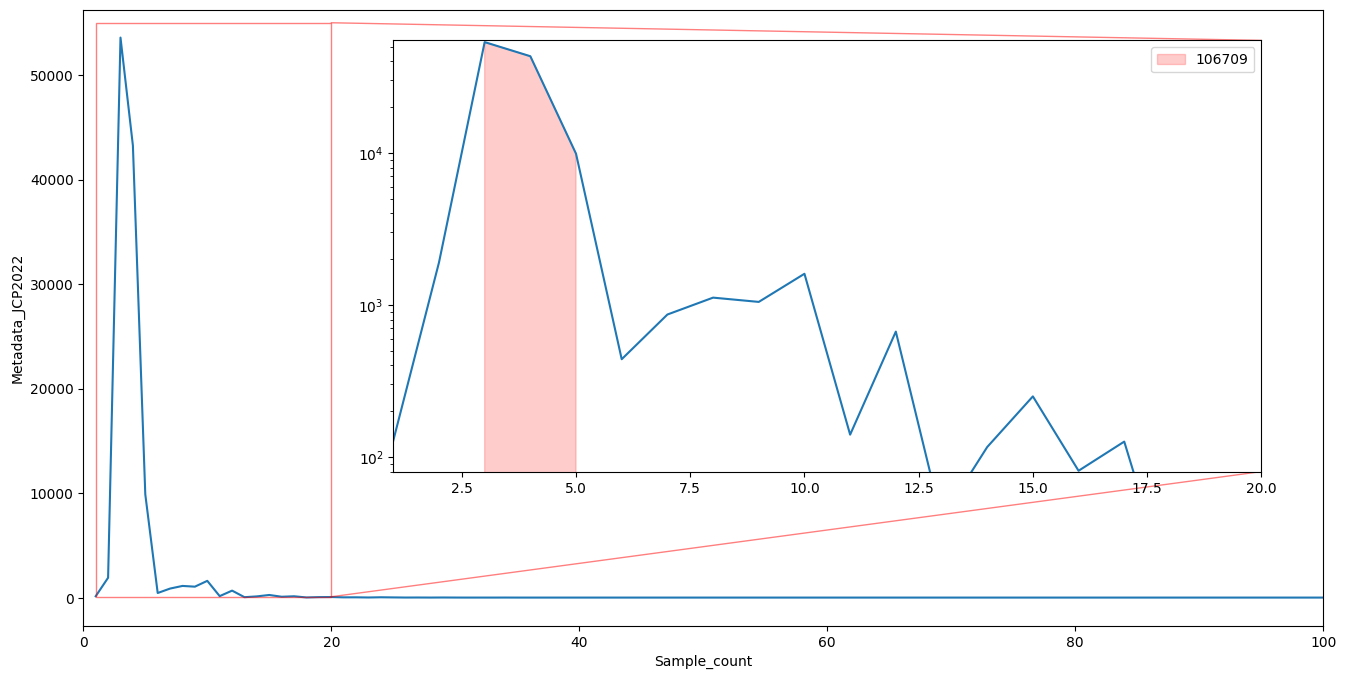

In [1158]:
fig, ax1 = plt.subplots(1, figsize=(16,8))

df = (compounds_info.group_by("Sample_count")
             .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="Sample_count"))

sns.lineplot(df,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax1)

ax1.set_xlim(0, 100)
ax2 = ax1.inset_axes([0.25, 0.25, 0.7, 0.7])

sns.lineplot(df,
            x="Sample_count",
            y="Metadata_JCP2022",
            ax=ax2)

ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_xlim(1, 20)
ax2.set_yscale("log")
ax2.set_ylim(80, 55000)
x = df.select(pl.col("Sample_count")).to_numpy().reshape(-1)
y = df.select(pl.col("Metadata_JCP2022")).to_numpy().reshape(-1)
mask = (3 <= x)&(x < 6)
ax2.fill_between(x=x,
                 y1=y,
                 where=mask,
                 color='r',
                 alpha=0.2,
                 label=f"{y[mask].sum()}")
ax2.legend()

ax1.indicate_inset_zoom(ax2, edgecolor=[1,0,0])

/tmp/ipykernel_2820607/943141062.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_2820607/943141062.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0, 0.5, 'Compound_count (.10$^{3}$)')

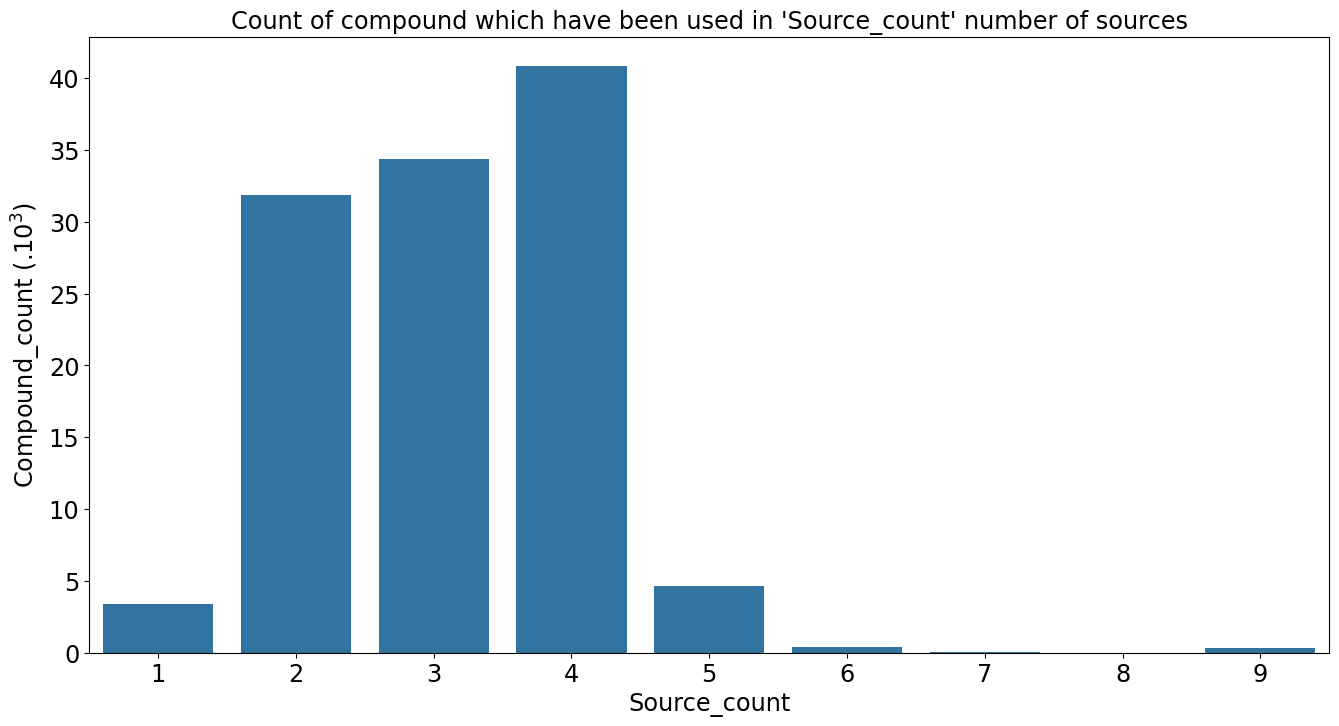

In [1159]:
fig, ax = plt.subplots(1, figsize=(16,8))
#sns.set_theme()
sns.barplot((compounds_info.group_by("Unique_Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())
            .with_columns(pl.col("Unique_Metadata_Source").alias("Source_count"),
                          (pl.col("Metadata_JCP2022")/1000).alias("Compound_count"))),
            x="Source_count",
            y="Compound_count",
            ax=ax)
ax.set_title("Count of compound which have been used in 'Source_count' number of sources", fontsize='xx-large')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize='xx-large')
ax.set_xlabel("Source_count", fontsize='xx-large')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize='xx-large')
ax.set_ylabel("Compound_count (.10$^{3}$)", fontsize='xx-large')

/tmp/ipykernel_2820607/2989883956.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_2820607/2989883956.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0, 0.5, 'Compound_count (.10$^{3}$)')

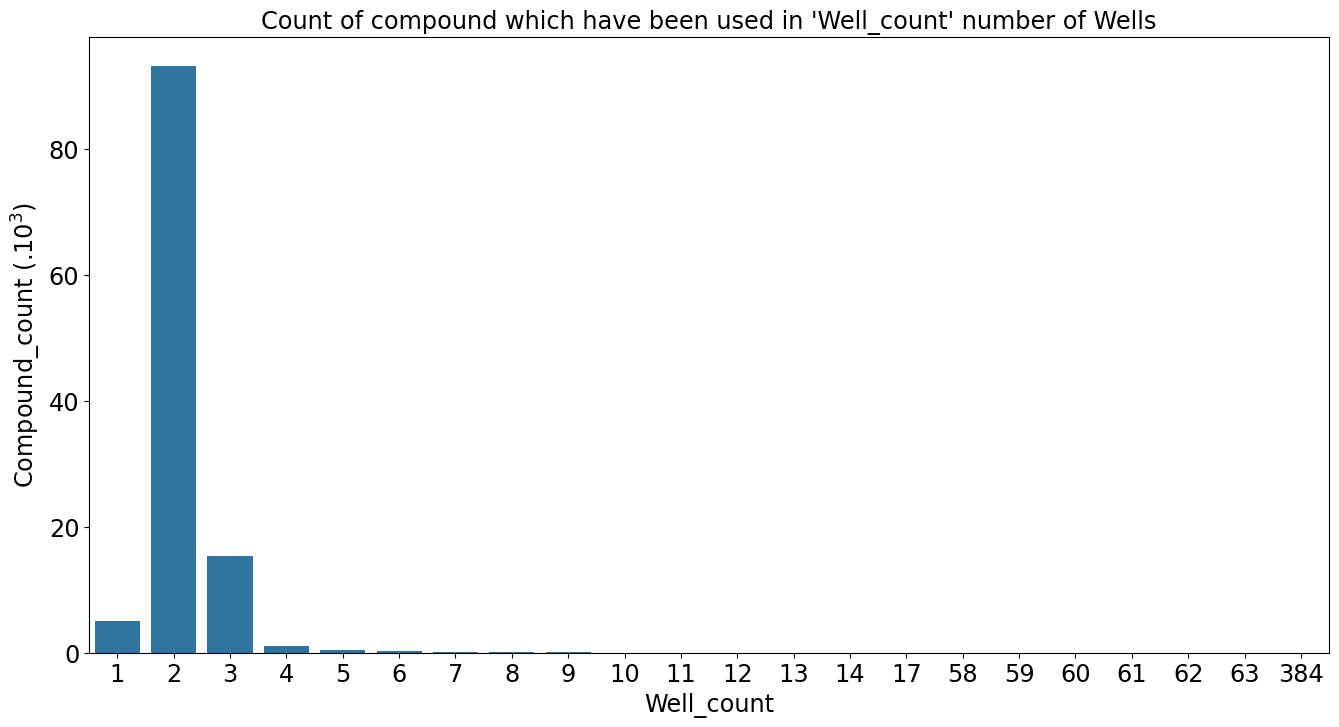

In [1160]:
fig, ax = plt.subplots(1, figsize=(16,8))
#sns.set_theme()
sns.barplot((compounds_info.group_by("Unique_Metadata_Well").agg(pl.col("Metadata_JCP2022").n_unique())
            .with_columns(pl.col("Unique_Metadata_Well").alias("Well_count"),
                          (pl.col("Metadata_JCP2022")/1000).alias("Compound_count"))),
            x="Well_count",
            y="Compound_count",
            ax=ax)
ax.set_title("Count of compound which have been used in 'Well_count' number of Wells", fontsize='xx-large')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize='xx-large')
ax.set_xlabel("Well_count", fontsize='xx-large')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize='xx-large')
ax.set_ylabel("Compound_count (.10$^{3}$)", fontsize='xx-large')

/tmp/ipykernel_2820607/264705101.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipykernel_2820607/264705101.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Text(0, 0.5, 'Compound_count (.10$^{3}$)')

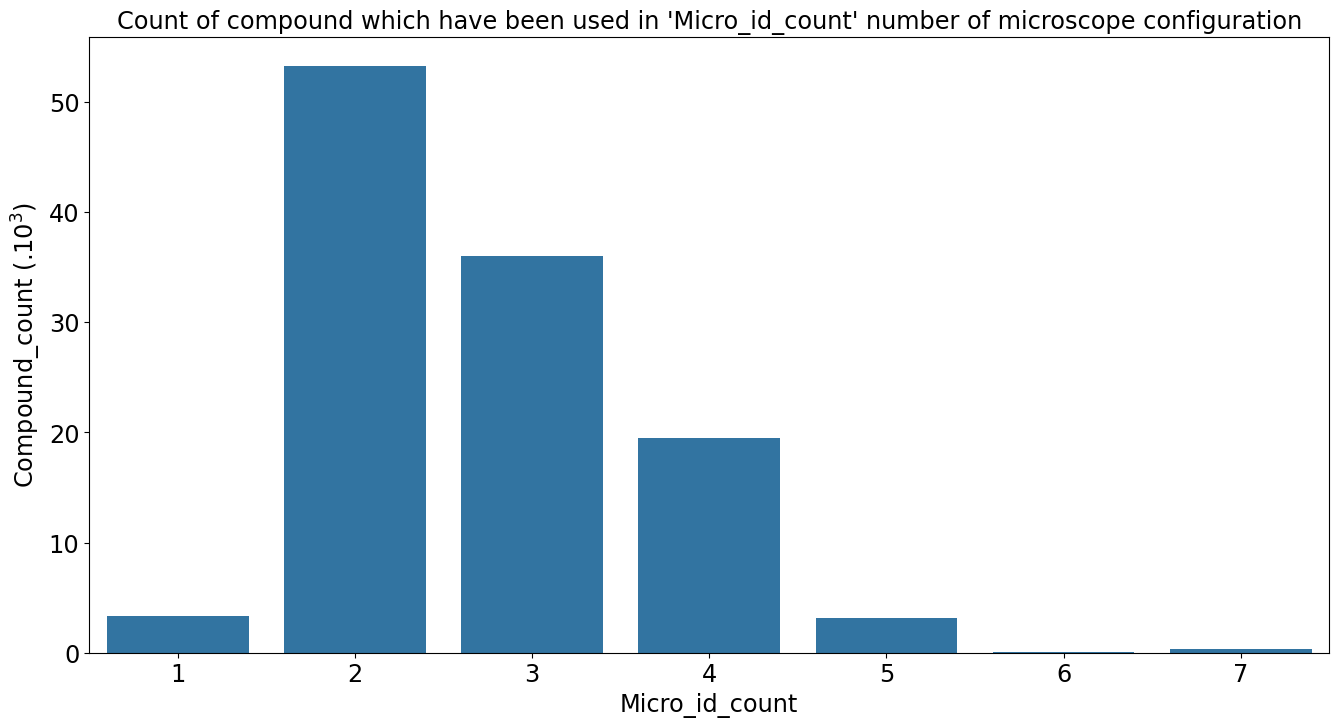

In [1161]:
fig, ax = plt.subplots(1, figsize=(16,8))
#sns.set_theme()
sns.barplot((compounds_info.group_by("Unique_Micro_id").agg(pl.col("Metadata_JCP2022").n_unique())
            .with_columns(pl.col("Unique_Micro_id").alias("Micro_id_count"),
                          (pl.col("Metadata_JCP2022")/1000).alias("Compound_count"))),
            x="Micro_id_count",
            y="Compound_count",
            ax=ax)
ax.set_title("Count of compound which have been used in 'Micro_id_count' number of microscope configuration", 
             fontsize='xx-large')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize='xx-large')
ax.set_xlabel("Micro_id_count", fontsize='xx-large')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize='xx-large')
ax.set_ylabel("Compound_count (.10$^{3}$)", fontsize='xx-large')

In [1162]:
Micro_cross_well = (
    (compounds_info.group_by("Unique_Micro_id", "Unique_Metadata_Well")
     .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by=["Unique_Micro_id", "Unique_Metadata_Well"]))
     .pivot(index="Unique_Micro_id", 
            columns="Unique_Metadata_Well", 
            values="Metadata_JCP2022"))
Micro_cross_well

Unique_Micro_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,58,59,60,61,62,63,384
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1,2936,302,100,21,5,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,1994,50887,392,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,111,34072,1837,16,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,25,7945,10828,466,104,28,21,44,27,6,4,null,null,null,null,null,null,null,null,null,null,null
5,null,17,2188,439,263,136,63,46,23,13,6,1,1,1,null,null,null,null,null,null,null,null
6,null,null,2,61,8,8,12,4,4,2,null,null,null,null,null,null,null,null,null,null,null,null
7,null,null,62,36,44,71,24,19,23,10,8,null,2,2,1,3,1,1,1,1,1,1


In [1163]:
Source_cross_well = (
    (compounds_info.group_by("Unique_Metadata_Source", "Unique_Metadata_Well")
     .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by=["Unique_Metadata_Source", "Unique_Metadata_Well"]))
     .pivot(index="Unique_Metadata_Source", 
            columns="Unique_Metadata_Well", 
            values="Metadata_JCP2022"))
Source_cross_well

Unique_Metadata_Source,1,2,3,4,5,6,7,8,9,10,11,12,14,13,17,58,59,60,61,62,63,384
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1,2936,302,100,21,5,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,1923,29545,392,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,118,34153,70,3,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,89,29189,11298,133,12,27,20,44,27,6,4,null,null,null,null,null,null,null,null,null,null,null
5,null,34,3485,736,256,50,27,13,7,7,2,1,1,null,null,null,null,null,null,null,null,null
6,null,null,1,111,106,91,38,34,18,7,4,null,null,1,null,null,null,null,null,null,null,null
7,null,null,null,null,6,4,11,5,2,1,null,null,null,null,null,null,null,null,null,null,null,null
8,null,null,1,null,null,null,1,1,null,1,null,null,null,null,null,null,null,null,null,null,null,null
9,null,null,62,36,39,71,23,16,23,9,8,null,2,2,1,3,1,1,1,1,1,1


In [1164]:
Source_cross_micro = (
    (compounds_info.group_by("Unique_Metadata_Source", "Unique_Micro_id")
     .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by=["Unique_Metadata_Source", "Unique_Micro_id"]))
     .pivot(index="Unique_Metadata_Source", 
            columns="Unique_Micro_id", 
            values="Metadata_JCP2022"))
Source_cross_micro

Unique_Metadata_Source,1,2,3,4,5,6,7
u32,u32,u32,u32,u32,u32,u32,u32
1,3366,null,null,null,null,null,null
2,null,31860,null,null,null,null,null
3,null,21414,12931,null,null,null,null
4,null,null,23106,17743,null,null,null
5,null,null,null,1755,2864,null,null
6,null,null,null,null,333,78,null
7,null,null,null,null,null,22,7
8,null,null,null,null,null,1,3
9,null,null,null,null,null,null,301


In [1165]:
Well_cross_sample = (
    (compounds_info.group_by("Unique_Metadata_Well", "Sample_count")
     .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by=["Unique_Metadata_Well", "Sample_count"]))
     .pivot(index="Unique_Metadata_Well", 
            columns="Sample_count", 
            values="Metadata_JCP2022"))
Well_cross_sample

Unique_Metadata_Well,1,2,3,4,5,7,6,8,9,10,12,15,11,13,17,20,125,133,134,135,136,14,16,139,141,18,19,21,22,23,129,138,140,142,143,146,…,158,276,31,32,39,41,157,162,281,282,283,284,34,35,154,156,161,170,168,287,289,47,173,290,58,167,179,185,6864,7288,7484,7512,7420,7415,7637,7509,109225
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
1,128,1775,231,146,2784,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,null,125,52958,33559,5579,633,66,13,9,271,7,3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,null,null,393,9547,1424,7,297,972,817,1213,588,31,53,1,2,1,1,1,4,1,56,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,null,null,null,null,88,163,76,96,200,92,32,113,40,11,65,5,null,null,null,1,null,20,3,4,31,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5,null,null,null,null,null,59,null,25,11,8,4,87,5,13,48,10,null,null,null,null,null,54,40,2,14,3,8,3,7,1,1,1,1,2,6,12,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
6,null,null,null,null,null,null,null,10,9,3,null,10,null,4,3,20,null,null,null,null,null,31,34,null,null,5,13,5,13,1,null,null,1,1,1,38,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
7,null,null,null,null,null,null,null,null,null,15,2,4,3,1,5,11,null,null,null,null,null,5,2,null,null,2,17,6,5,1,null,null,null,null,null,2,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
8,null,null,null,null,null,null,null,null,null,null,7,2,39,null,1,5,null,null,null,null,1,null,1,null,null,2,7,8,1,1,null,null,null,null,null,null,…,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
9,null,null,null,null,null,null,null,null,null,null,27,null,null,1,null,1,null,null,null,null,null,1,1,null,null,null,null,null,null,4,null,null,null,null,null,null,…,2,null,1,2,1,1,1,1,1,5,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


# 4) Compounds seletion

### a) Comparable amount of sample.
Compounds should have a comparable amount of sample. Otherwise, compounds with a larger amount of sample has a better chance to be predicted and it leads to imbalance in classification.
But the number of sample is highly corelated to the number of different well used per compounds. So by cutting to hard, the number of well is higly reduced. 
Let's see the result with ```min_sample = 3``` and ```max_sample = 6```

In [1166]:
# Define all cutoff discuss in each section.
sample_cutoff = [3, 6]
well_cutoff = [2, 384]
micro_cutoff = [3, 10]
source_cutoff = [3, 10]

In [1167]:
compounds_info_filter = compounds_info.filter(
    (pl.col("Sample_count") >= sample_cutoff[0])&
    (pl.col("Sample_count") <= sample_cutoff[1]))

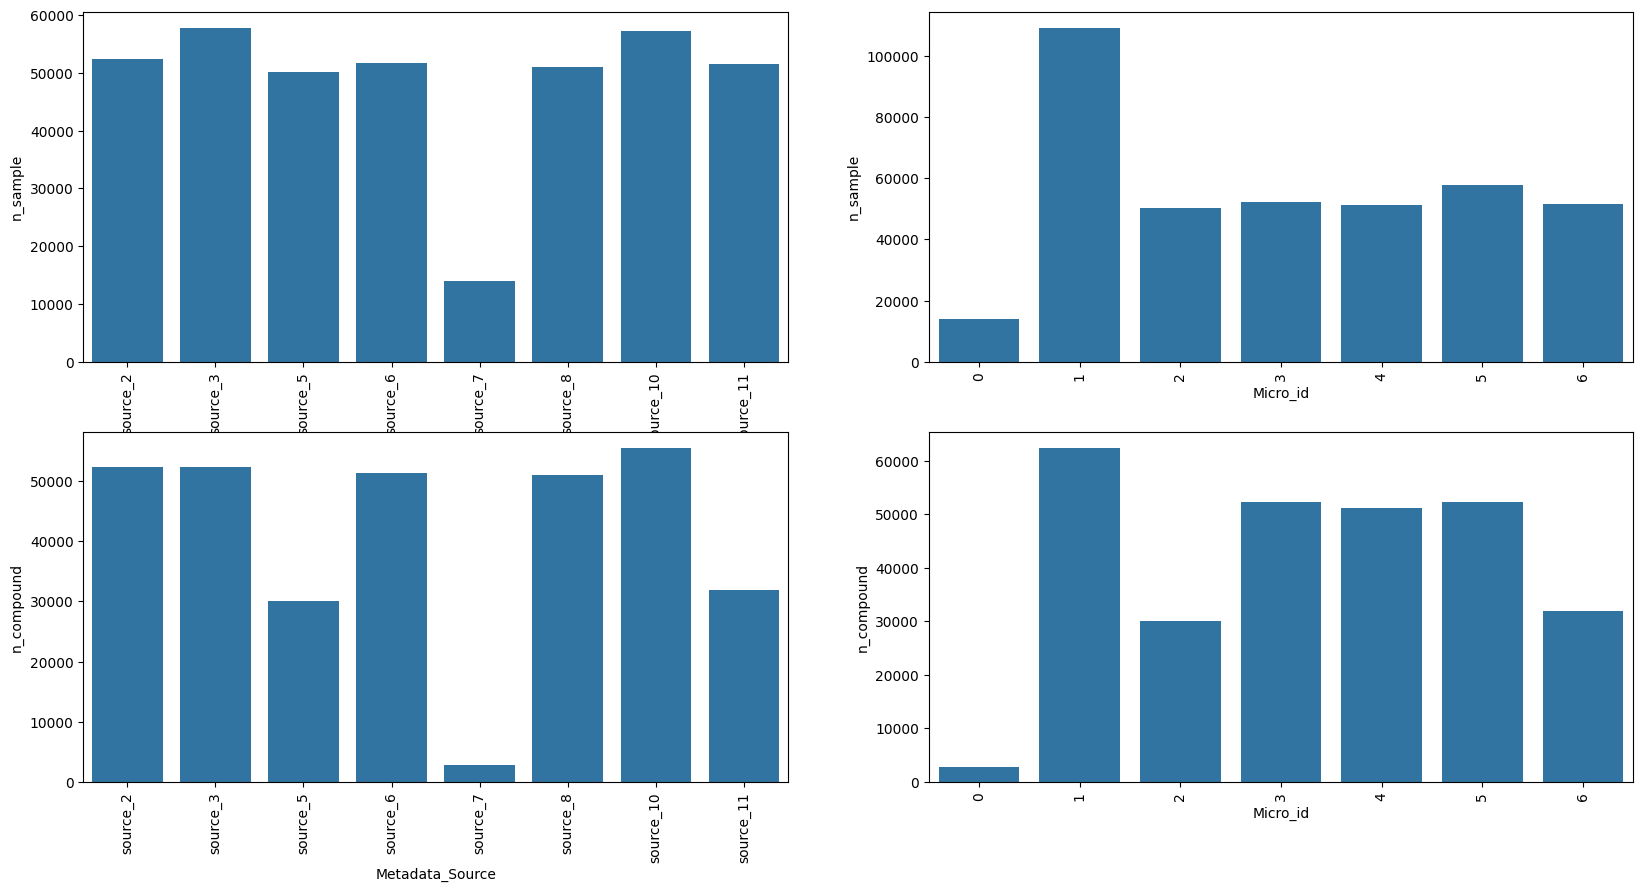

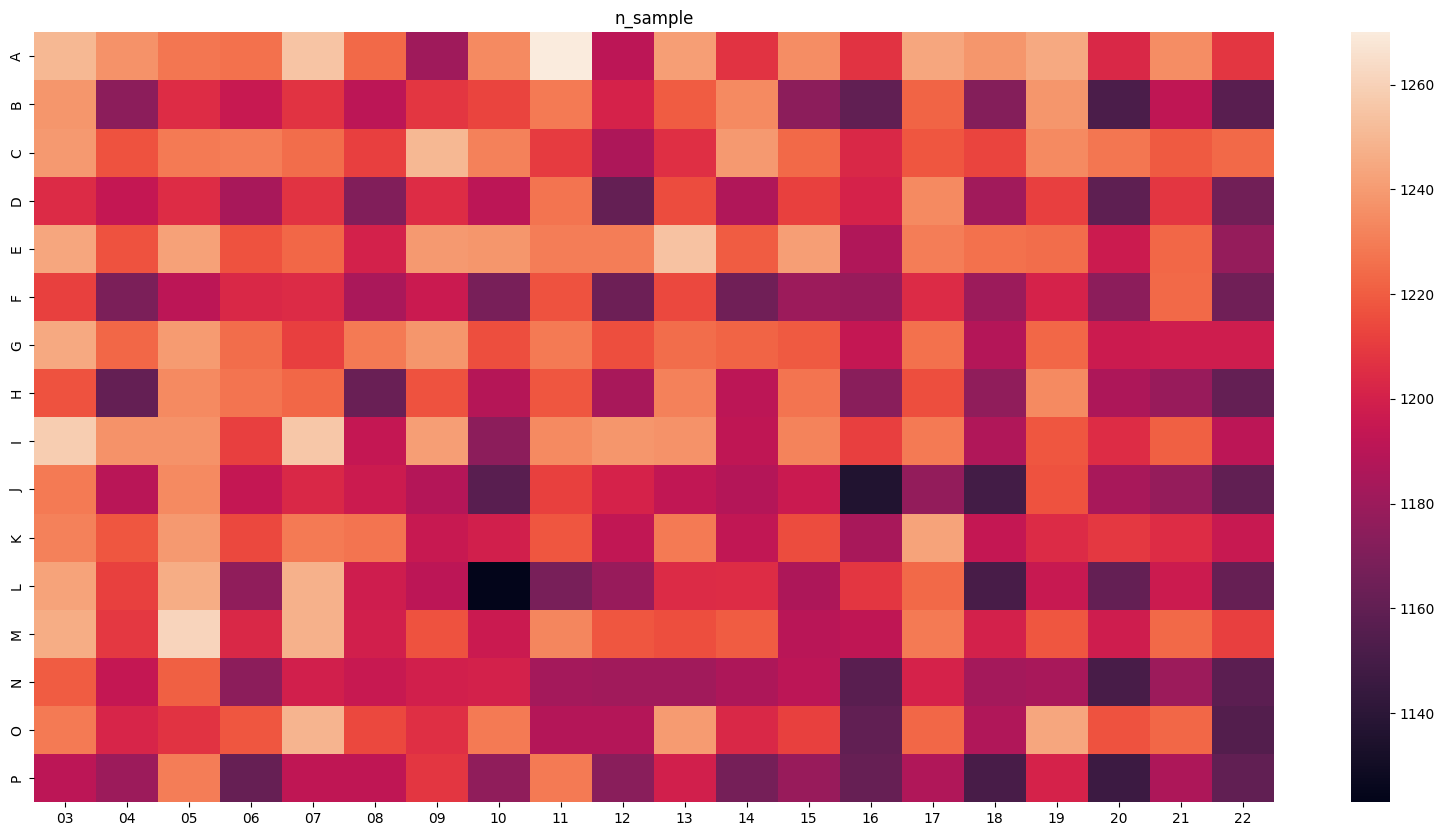

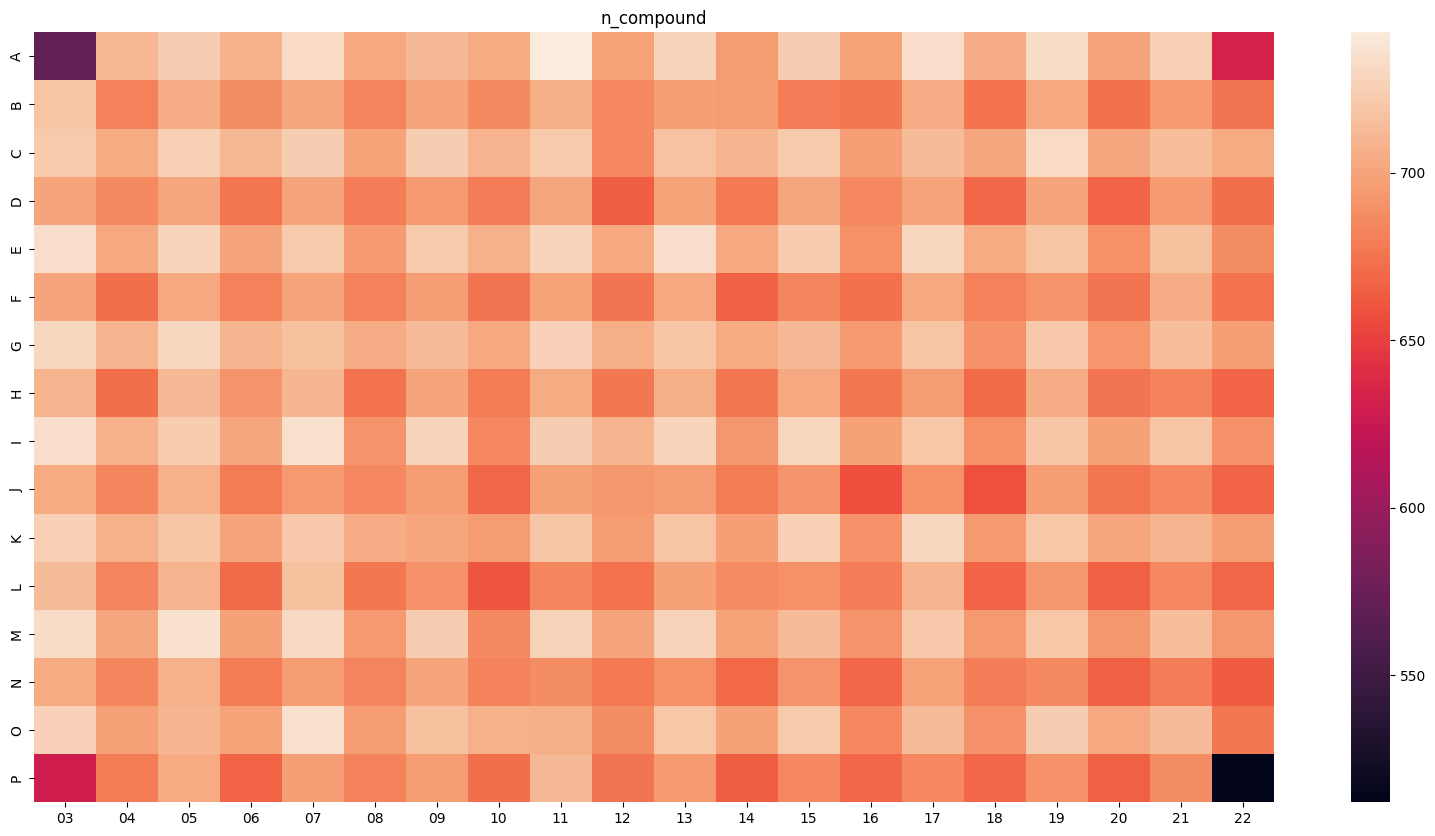

In [1168]:
show_distribution(filter_merge_table.join(compounds_info_filter.select(pl.col("Metadata_JCP2022")),
                        on="Metadata_JCP2022",
                        how="inner"))

### b) Enough microscope and well configuration tested
Other thing which will alter the image is the number of microscope tested and the number of well. The nu;ber of source is not so important as the condition should not differ much between sources.

In [1169]:
((compounds_info_filter.group_by("Unique_Micro_id", "Unique_Metadata_Well")
     .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by=["Unique_Metadata_Well","Unique_Micro_id"]))
     .pivot(index="Unique_Micro_id", 
            columns="Unique_Metadata_Well", 
            values="Metadata_JCP2022"))

Unique_Micro_id,1,2,3,4
u32,u32,u32,u32,u32
1,2767,37,null,null
2,260,50762,392,1
3,110,34011,1063,5
4,24,7350,9868,60
5,null,2,338,98


Let's decide a minimum of 3 well and 2 microscope configuration. 

In [1170]:
compounds_info_filter = compounds_info_filter.filter(
    (pl.col("Unique_Metadata_Well") >= well_cutoff[0])&
    (pl.col("Unique_Metadata_Well") <= well_cutoff[1])&
    (pl.col("Unique_Micro_id") >= micro_cutoff[0])&
    (pl.col("Unique_Micro_id") <= micro_cutoff[1])&
    (pl.col("Unique_Metadata_Source") >= source_cutoff[0])&
    (pl.col("Unique_Metadata_Source") <= source_cutoff[1]))

In [1171]:
((compounds_info_filter.group_by("Unique_Micro_id", "Unique_Metadata_Source")
     .agg(pl.col("Metadata_JCP2022").n_unique()).sort(by=["Unique_Metadata_Source","Unique_Micro_id"]))
     .pivot(index="Unique_Micro_id", 
            columns="Unique_Metadata_Source", 
            values="Metadata_JCP2022"))

Unique_Micro_id,3,4,5
u32,u32,u32,u32
3,12807,22272,null
4,null,16579,699
5,null,null,438


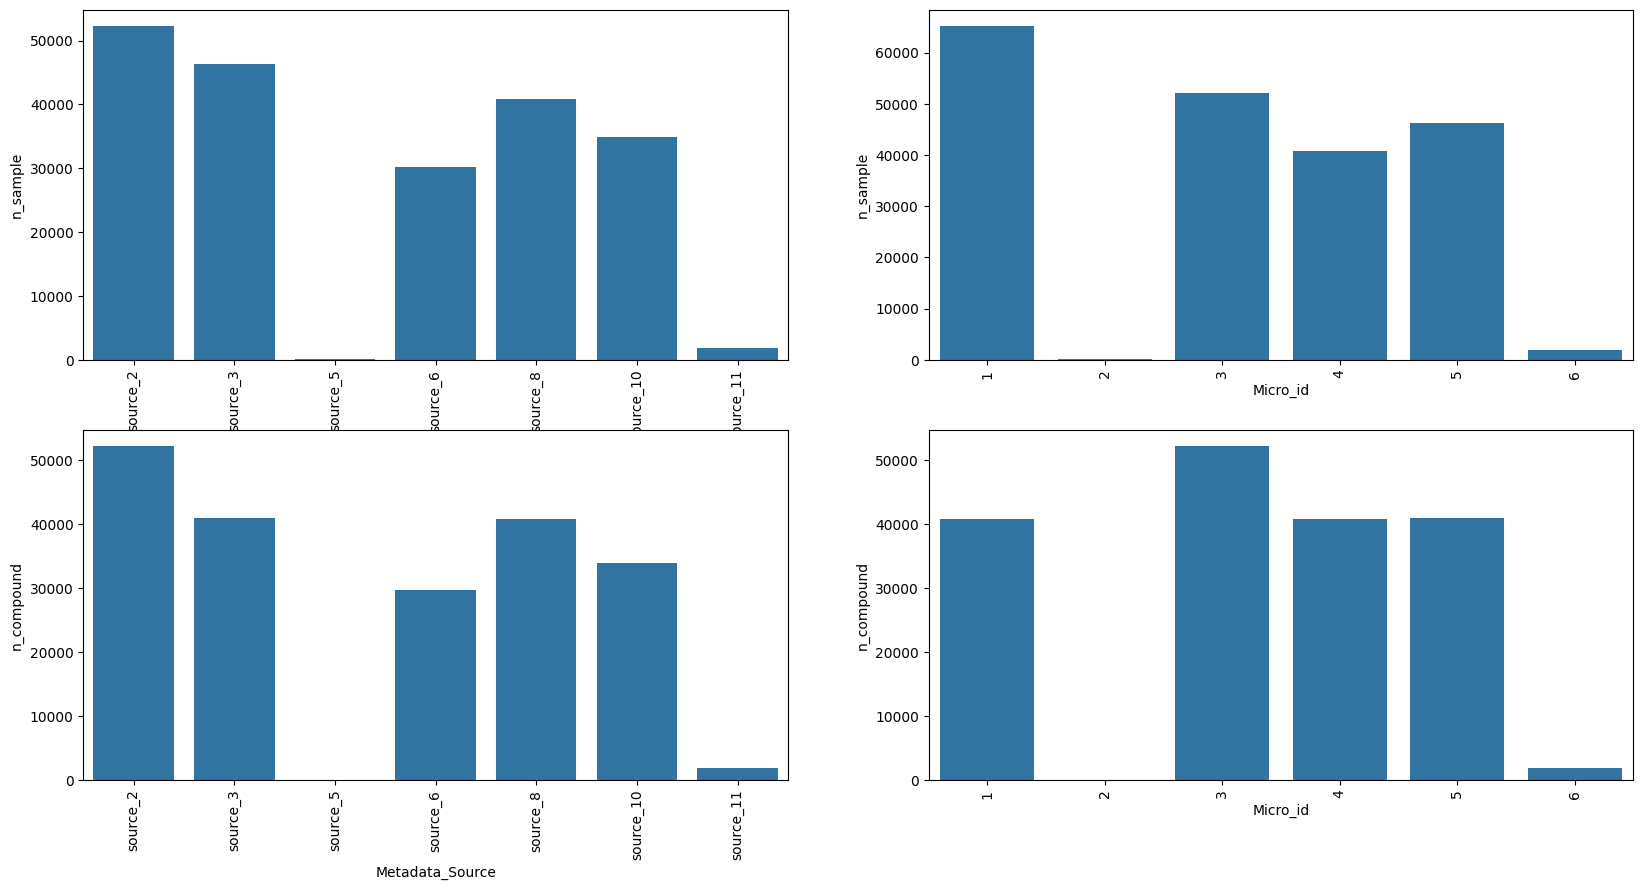

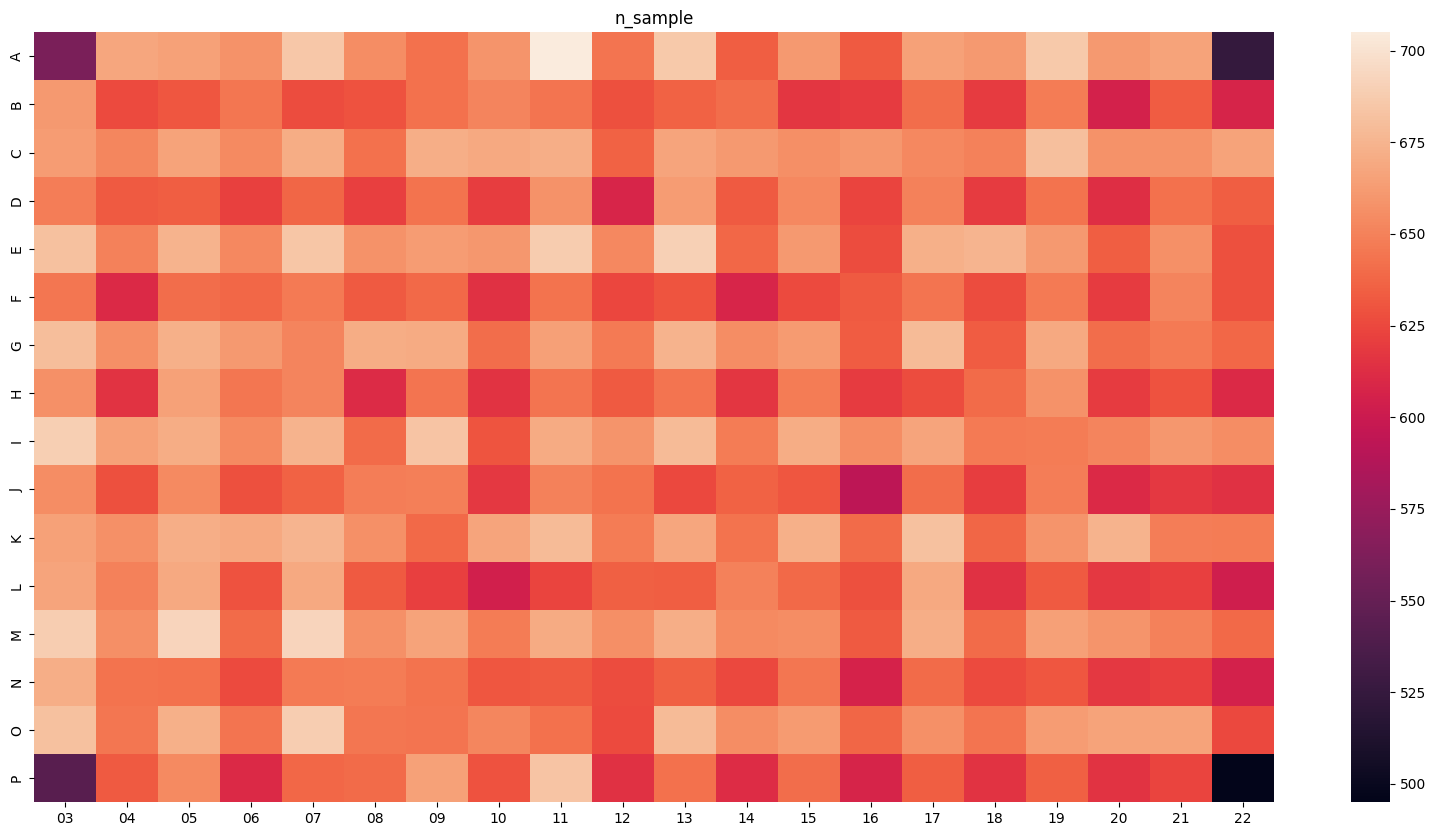

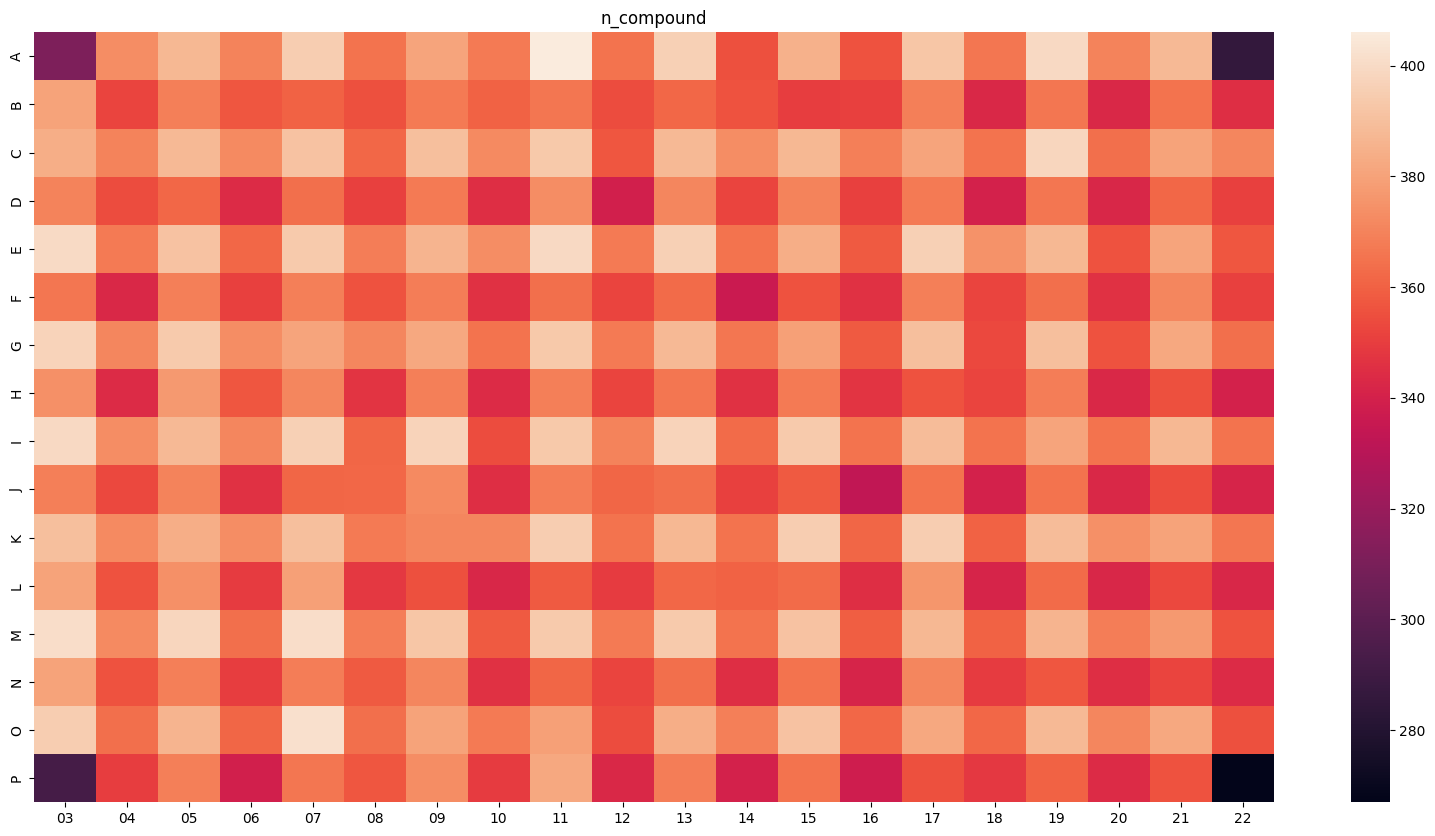

In [1172]:
show_distribution(filter_merge_table.join(compounds_info_filter.select(pl.col("Metadata_JCP2022")),
                        on="Metadata_JCP2022",
                        how="inner"))

Let's create a function which ensure that the threshold we decided of are always applied. 

In [1173]:
def Apply_threshold(subset):
    subset_info = (subset.group_by("Metadata_JCP2022")
                      .agg(pl.col("Metadata_InChIKey").count().alias("Sample_count"),
                           pl.col("Metadata_Source", "Metadata_Well", "Micro_id")
                           .n_unique().name.prefix("Unique_"))
                           )
    
    subset_info = subset_info.filter(
        (pl.col("Sample_count") >= sample_cutoff[0])&
        (pl.col("Sample_count") <= sample_cutoff[1])&
        (pl.col("Unique_Metadata_Well") >= well_cutoff[0])&
        (pl.col("Unique_Metadata_Well") <= well_cutoff[1])&
        (pl.col("Unique_Micro_id") >= micro_cutoff[0])&
        (pl.col("Unique_Micro_id") <= micro_cutoff[1])&
        (pl.col("Unique_Metadata_Source") >= source_cutoff[0])&
        (pl.col("Unique_Metadata_Source") <= source_cutoff[1]))
    
    subset = subset.join(subset_info.select(pl.col("Metadata_JCP2022")),
                            on="Metadata_JCP2022",
                            how="inner")
    return subset

### c) Coherence of compounds among source and micro through down sampling. 
For random down sampling, use a seed (for reproductibility of the data) 

In [1174]:
#Chosen seed 
seed = 42

In [1175]:
subset = filter_merge_table.join(compounds_info_filter.select(pl.col("Metadata_JCP2022")),
                        on="Metadata_JCP2022",
                        how="inner").select(pl.col("Metadata_JCP2022", "Metadata_Source"))

subset.group_by("Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())

Metadata_Source,Metadata_JCP2022
str,u32
"""source_11""",1895
"""source_10""",33938
"""source_6""",29771
"""source_3""",40941
"""source_2""",52149
"""source_8""",40775
"""source_5""",41


Source 2 is over represented which is bad. A way to deal with it is to randomly remove compounds from source 2. Not necessarily remove the whole compounds but just the sample of this compounds which are in source 2. Then if a compound happen to be have been tested in less sources than 3, then this compound is removed. Also, Source 5 and 11 are under represented, so let's remove all compounds (not just the sample, the compounds directly) which are in those sources. 
#### Source 5 and 11 removal.

In [1176]:
subset = subset.join(
    (subset.filter(pl.col("Metadata_Source").str.contains("(_5$)|(_11$)"))
 .select(pl.col("Metadata_JCP2022").unique())),
    on="Metadata_JCP2022",
    how="anti")
#Ensure that we are dealing with unique pair of compound / 
#source as compound may have multiple sample pair source.
subset = subset.unique() 

In [1177]:
subset.group_by("Metadata_Source").agg(pl.col("Metadata_JCP2022").n_unique())

Metadata_Source,Metadata_JCP2022
str,u32
"""source_2""",50892
"""source_10""",32570
"""source_8""",39208
"""source_6""",28153
"""source_3""",40024


Since compounds can be tested in at least 3 sources. An interesting metric would be to see the number of compounds there is per pair. This gives an insight on how dependent sources are. 
A good idea is therefore to group per compounds and retrieve the list of sources where they come from. Problem, list of string are not easy to manipulate. Let's therefore do a mapping, from source to a primary number. By doing so, we can aggregate the pairs by multiplying those primary number which gives a unique identifiers per pair (per unicity of the deomposition in primary number).

In [1178]:
test = (subset.with_columns(
    pl.col("Metadata_Source").str.extract("\D+_(\d+)").cast(pl.Int16).alias("map"))
 .with_columns(
pl.when(pl.col("map") == 6)
    .then(pl.lit(5))
    .when(pl.col("map") == 8)
    .then(pl.lit(7))
    .when(pl.col("map") == 10)
    .then(pl.lit(11))
    .otherwise(pl.col("map"))
     .alias("map")))

In [1179]:
test.select(pl.struct(pl.col("Metadata_Source", "map")).unique())

Metadata_Source
struct[2]
"{""source_6"",5}"
"{""source_8"",7}"
"{""source_3"",3}"
"{""source_10"",11}"
"{""source_2"",2}"


In [1180]:
test.head()

Metadata_JCP2022,Metadata_Source,map
str,str,i16
"""JCP2022_095704…","""source_10""",11
"""JCP2022_001810…","""source_10""",11
"""JCP2022_061954…","""source_10""",11
"""JCP2022_097140…","""source_10""",11
"""JCP2022_048594…","""source_10""",11


In [1181]:
#Allow the transformation from the subset with all the information to a table like test. 
def Prepare_table(subset):
    return ((subset.select(pl.col("Metadata_JCP2022", "Metadata_Source"))
             .unique())
            .with_columns(
                pl.col("Metadata_Source").str.extract("\D+_(\d+)").cast(pl.Int16).alias("map"))
            .with_columns(
                pl.when(pl.col("map") == 6)
                .then(pl.lit(5))
                .when(pl.col("map") == 8)
                .then(pl.lit(7))
                .when(pl.col("map") == 10)
                .then(pl.lit(11))
                .otherwise(pl.col("map"))
                .alias("map")))

#### Down sampling of source 2 per 25000 compounds.

In [1201]:
test2 = test.join(test.filter(pl.col("map") == 2).sample(28000, seed=seed),
          on=["Metadata_JCP2022", "Metadata_Source", "map"],
          how="anti")

In [1202]:
test2 = test2.join(((test2.group_by("Metadata_JCP2022")
 .agg(pl.col("Metadata_Source").n_unique())).filter(pl.col("Metadata_Source") < 3)
            .select("Metadata_JCP2022")),
           on="Metadata_JCP2022",
           how="anti")

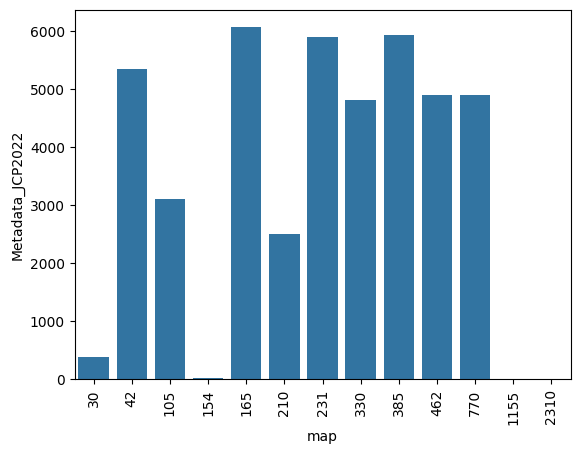

In [1203]:
def show_distribution_pair(test):
    sns.barplot(test.group_by("Metadata_JCP2022").agg(pl.col("map").product())
         .group_by("map").agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="map"),
                   x="map",
                   y="Metadata_JCP2022")
    plt.gca().tick_params(axis='x', rotation=90)
show_distribution_pair(test2)

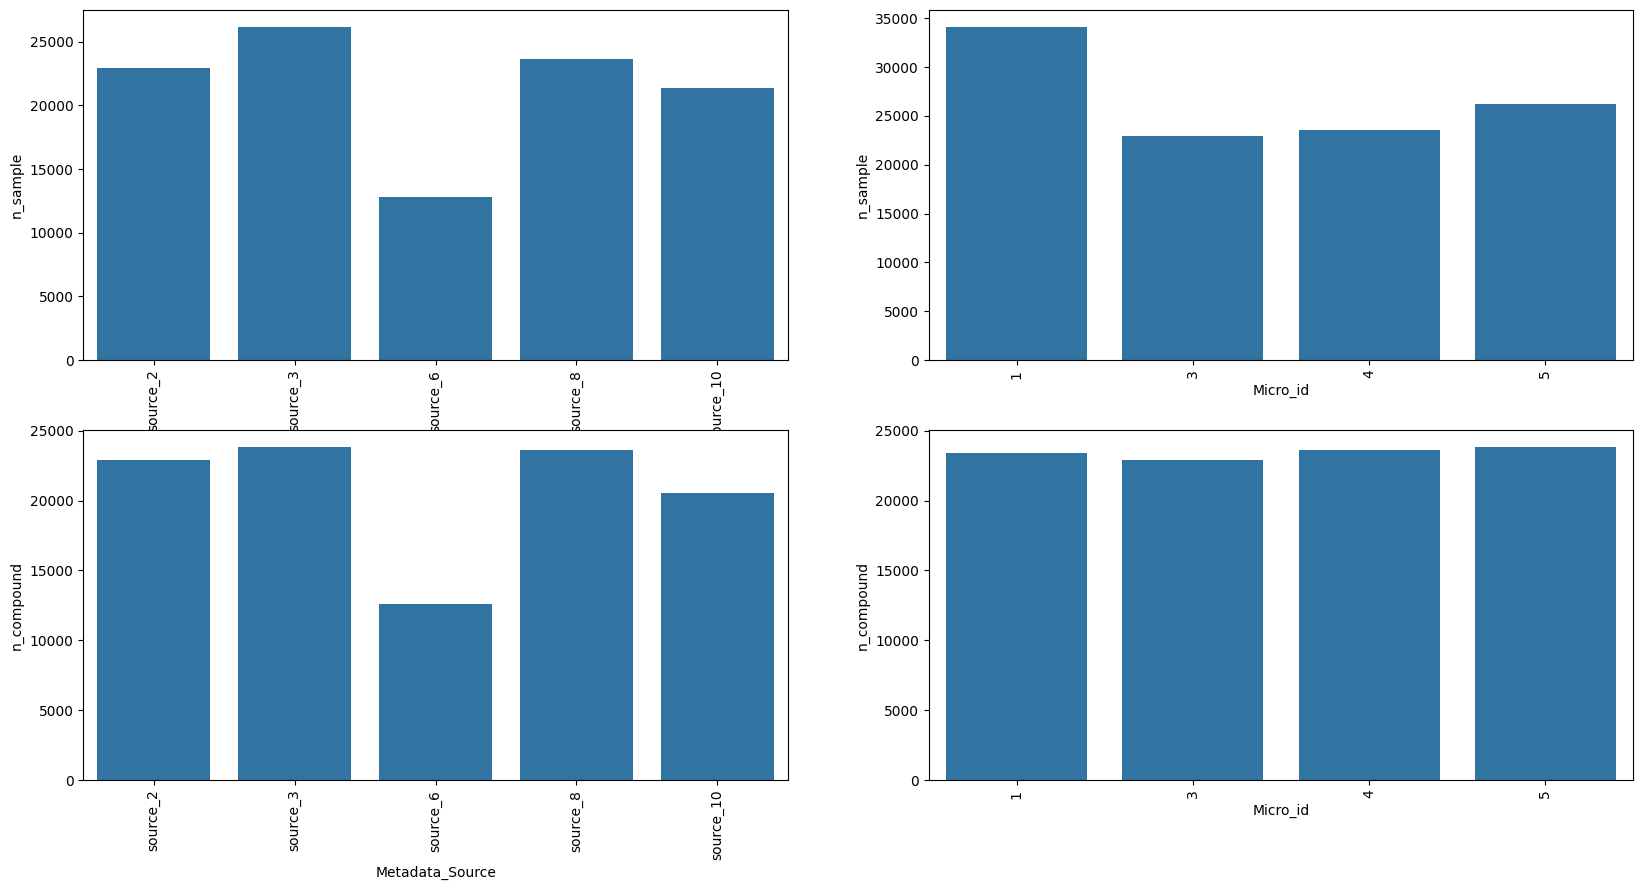

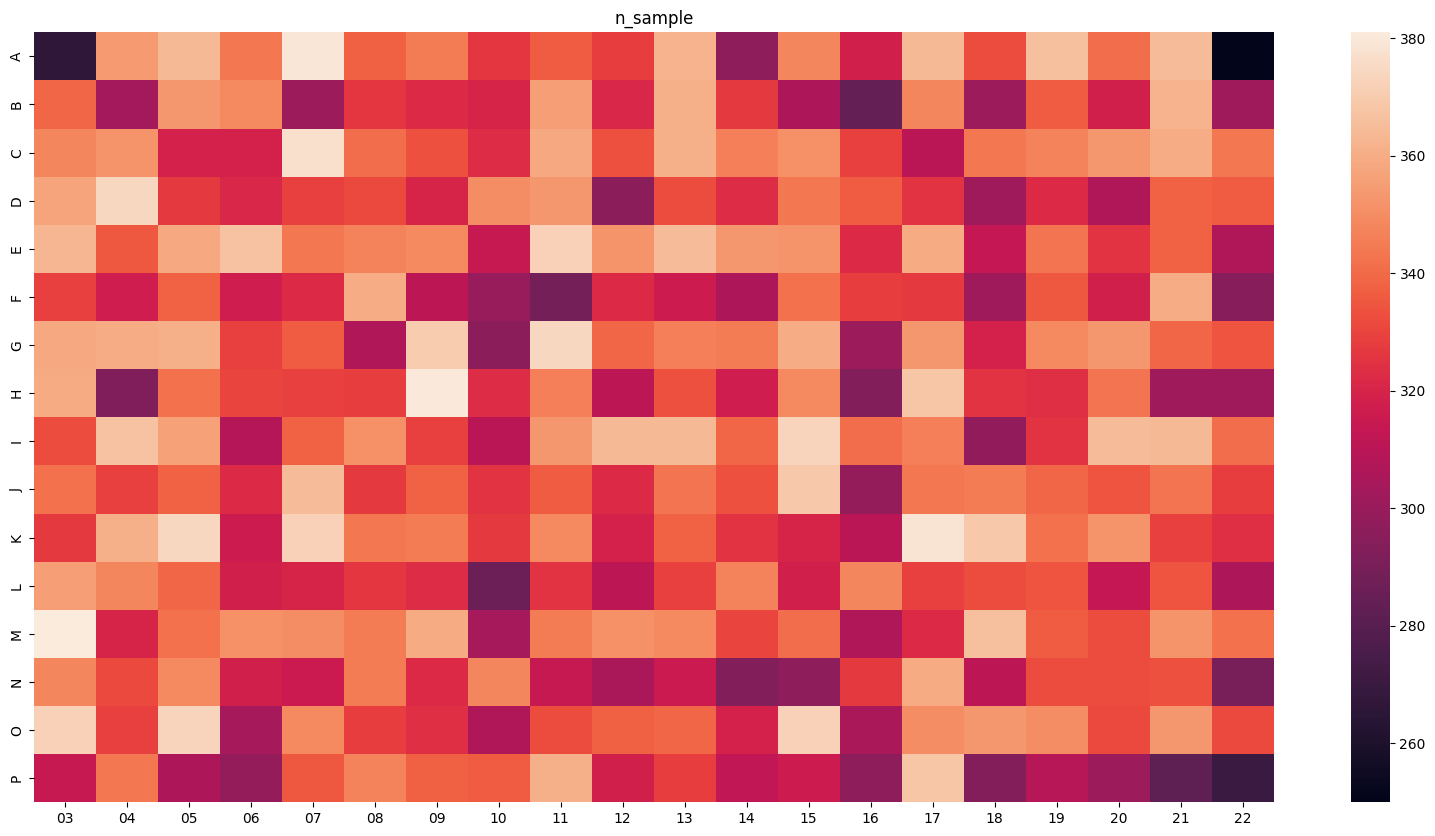

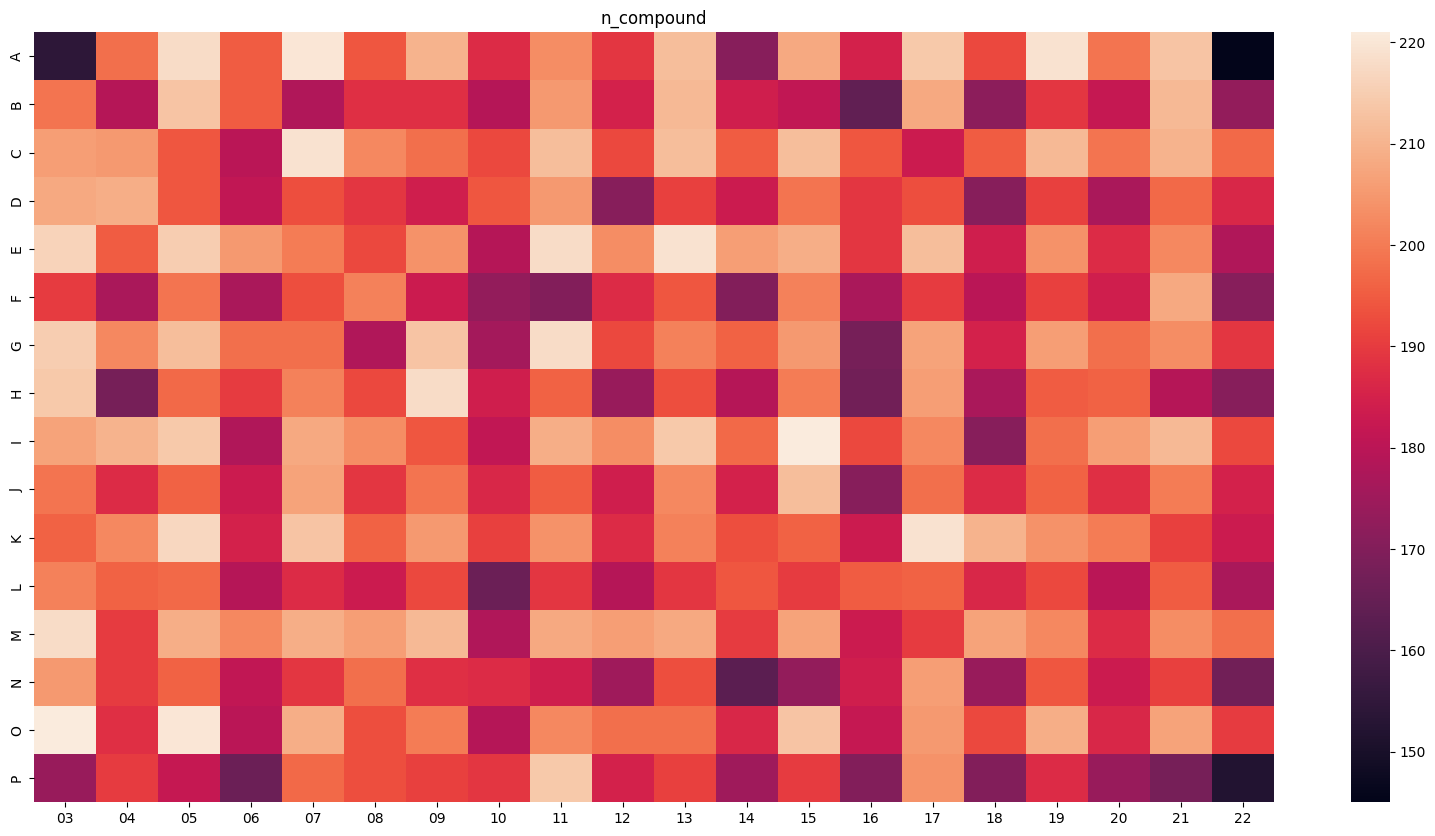

In [1204]:
subset2 = filter_merge_table.join(test2.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner")
subset2 = Apply_threshold(subset2)

show_distribution(subset2)

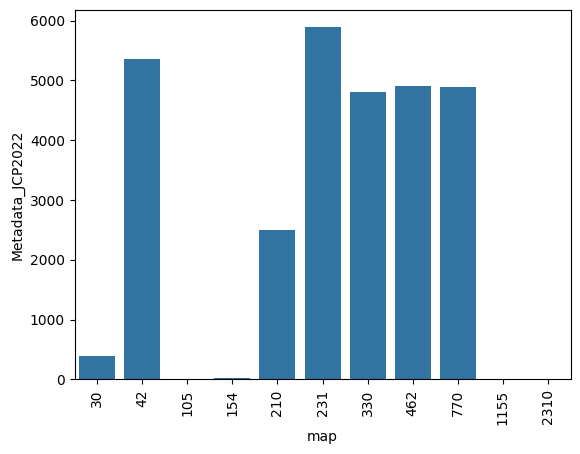

In [1205]:
test2 = Prepare_table(subset2)
show_distribution_pair(test2)

#### Balancing source 10 and 6. by removing randomly compounds from source 10. 

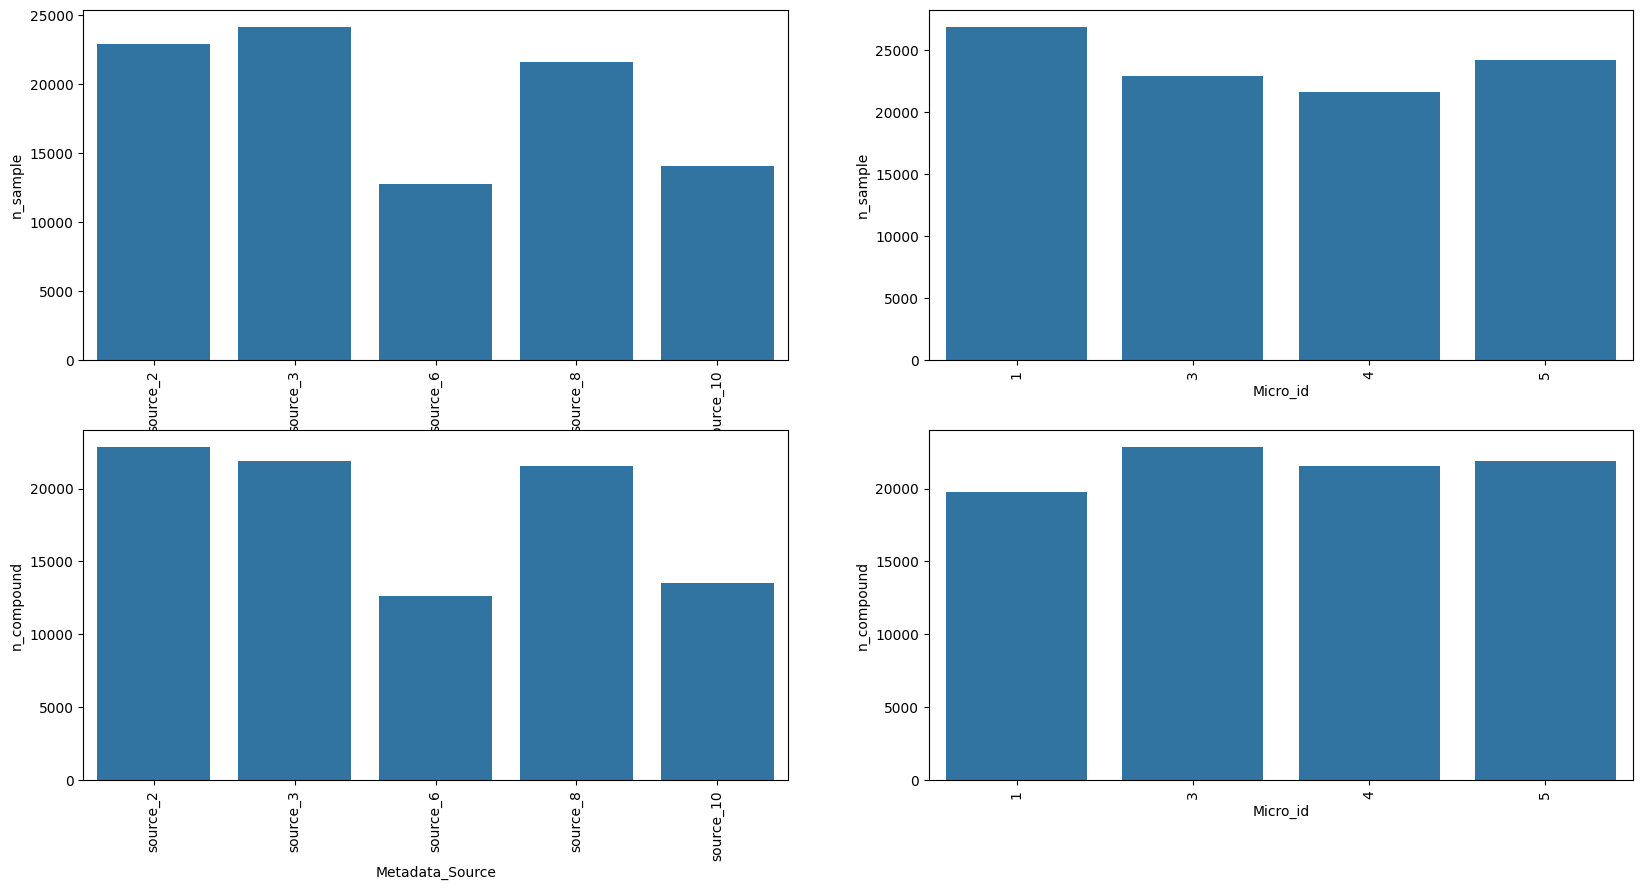

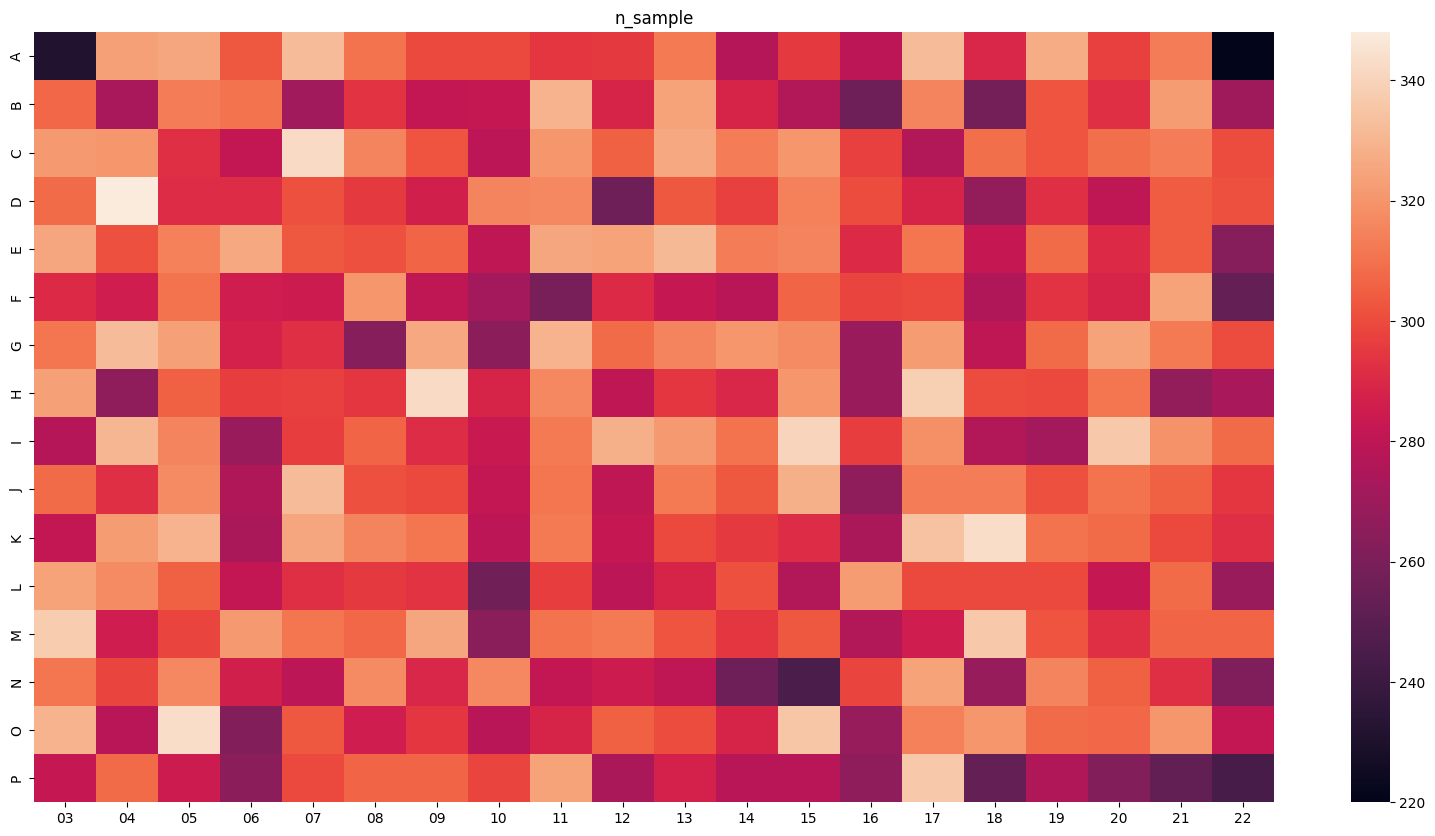

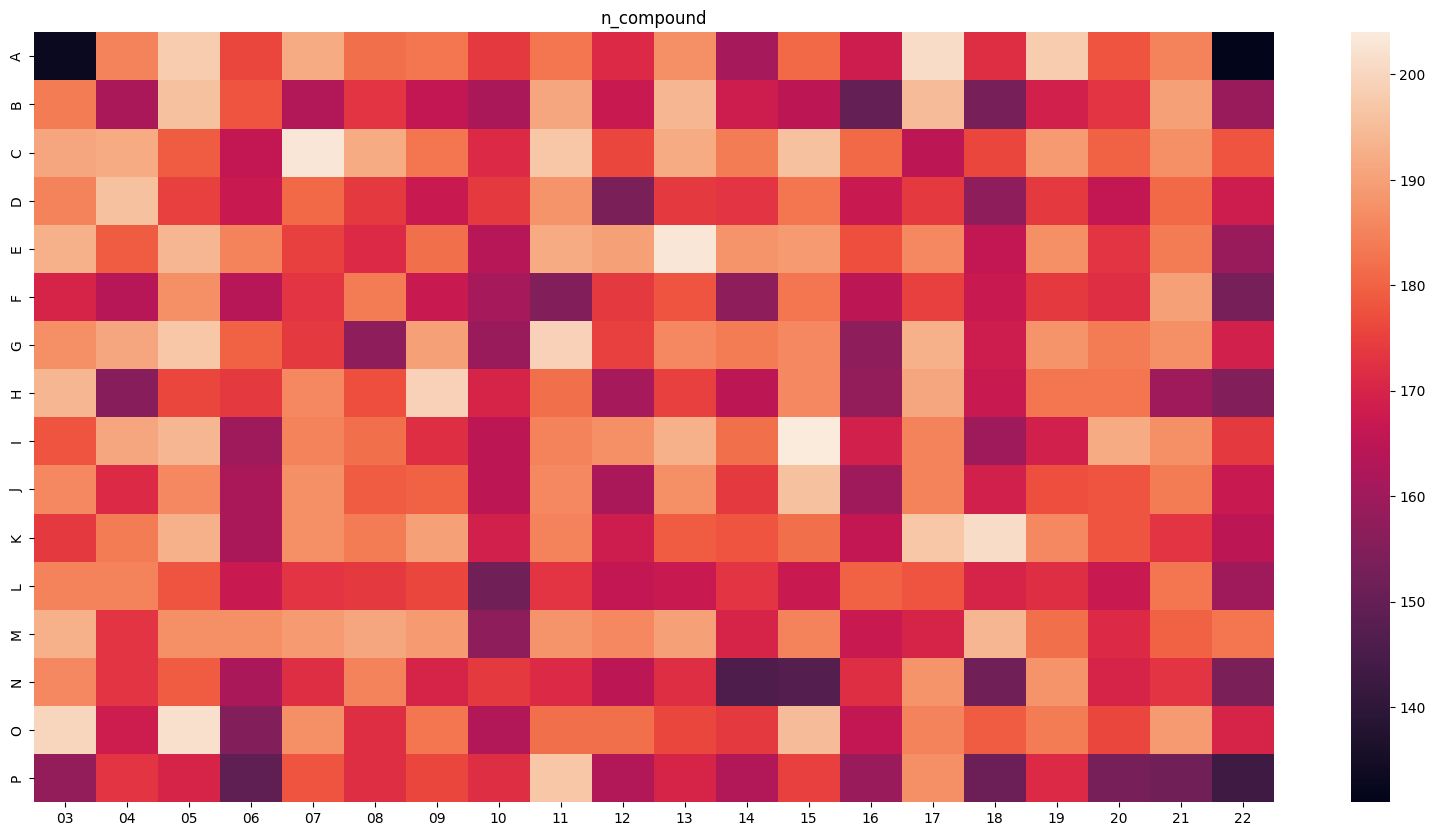

In [1206]:
test3 = test2.join(test2.filter(pl.col("map") == 11).sample(7000, seed=seed),
          on=["Metadata_JCP2022", "Metadata_Source", "map"],
          how="anti")

subset3 = filter_merge_table.join(test3.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner")
subset3 = Apply_threshold(subset3)

show_distribution(subset3)

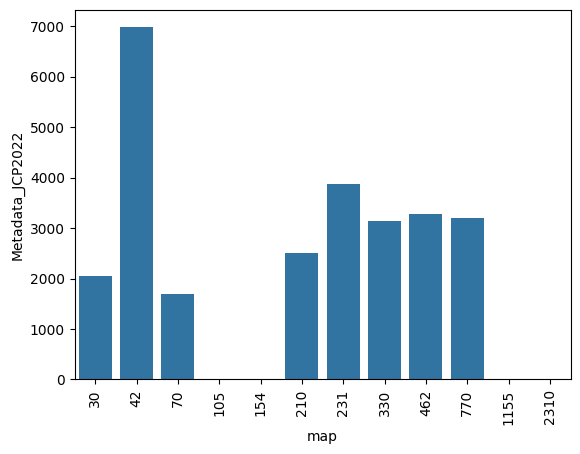

In [1207]:
test3 = Prepare_table(subset3)
show_distribution_pair(test3)

#### Balancing the source 2, 3, and 8 by tackling the group 42.

In [1209]:
test4 = (test3.group_by("Metadata_JCP2022").agg(pl.col("map").product())
 .filter(pl.col("map") == 42)
 .sort(by="Metadata_JCP2022")
 .select(pl.col("Metadata_JCP2022"))
 .sample(6500, seed=seed))

test4 = test3.join(test4,
                   on=["Metadata_JCP2022"],
                   how="anti")

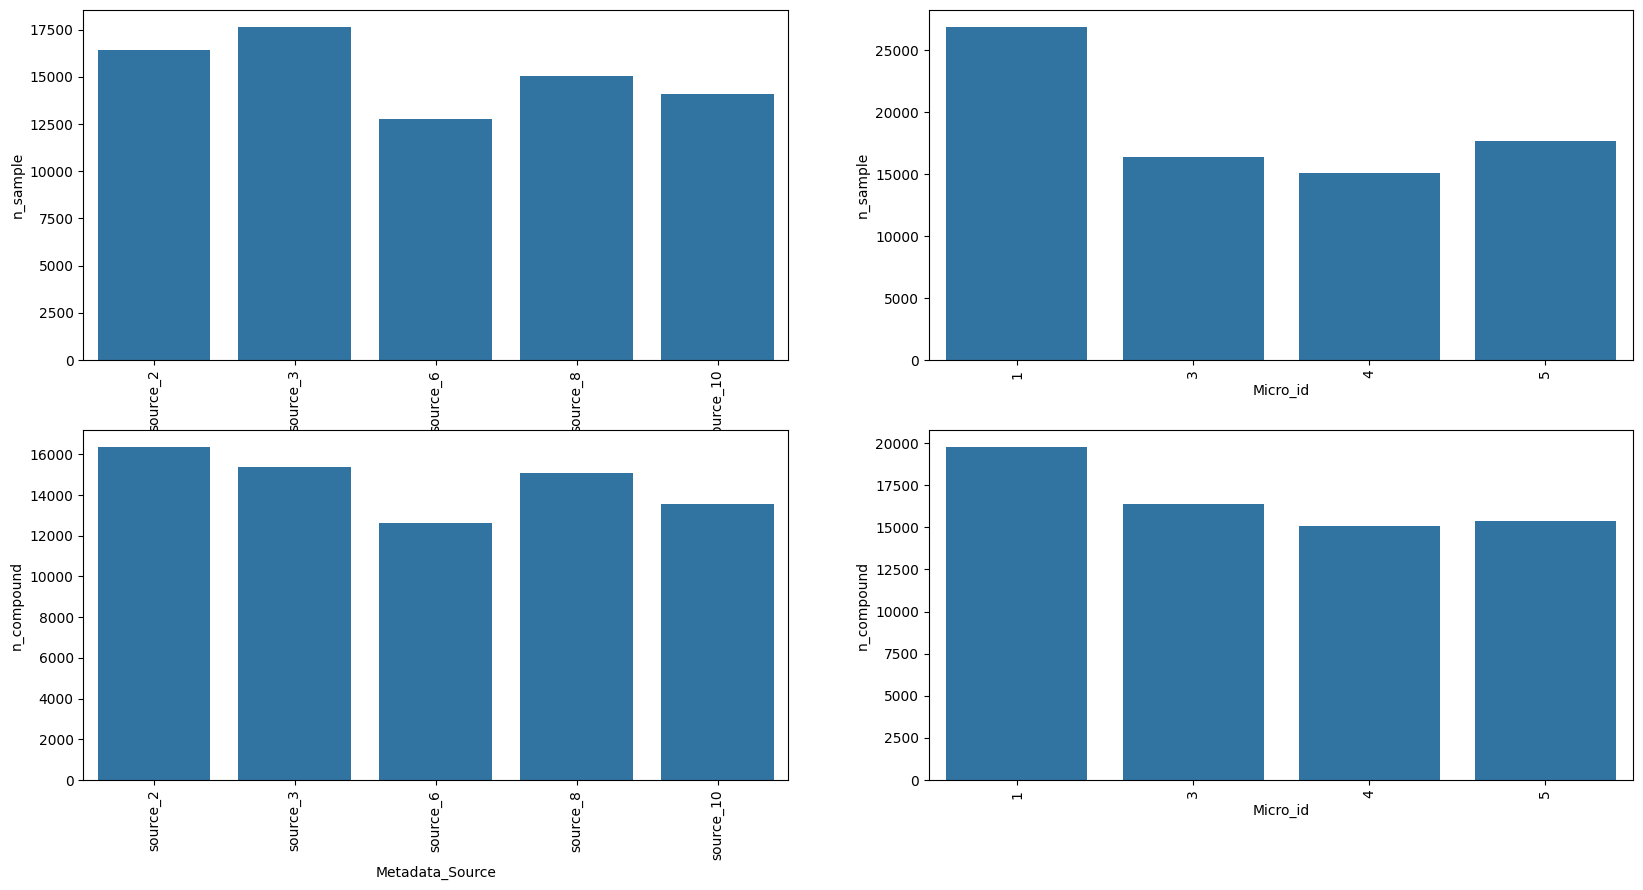

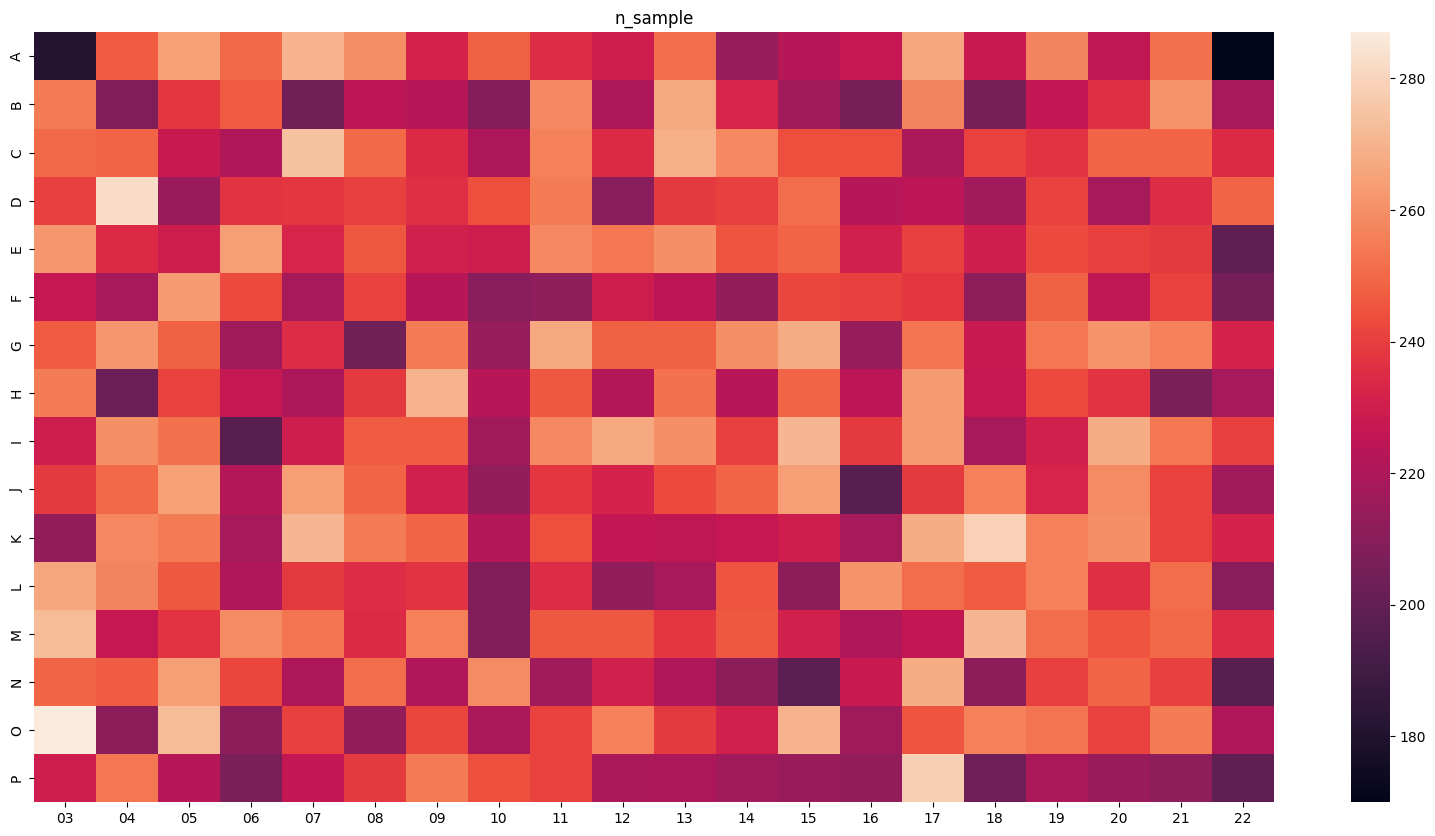

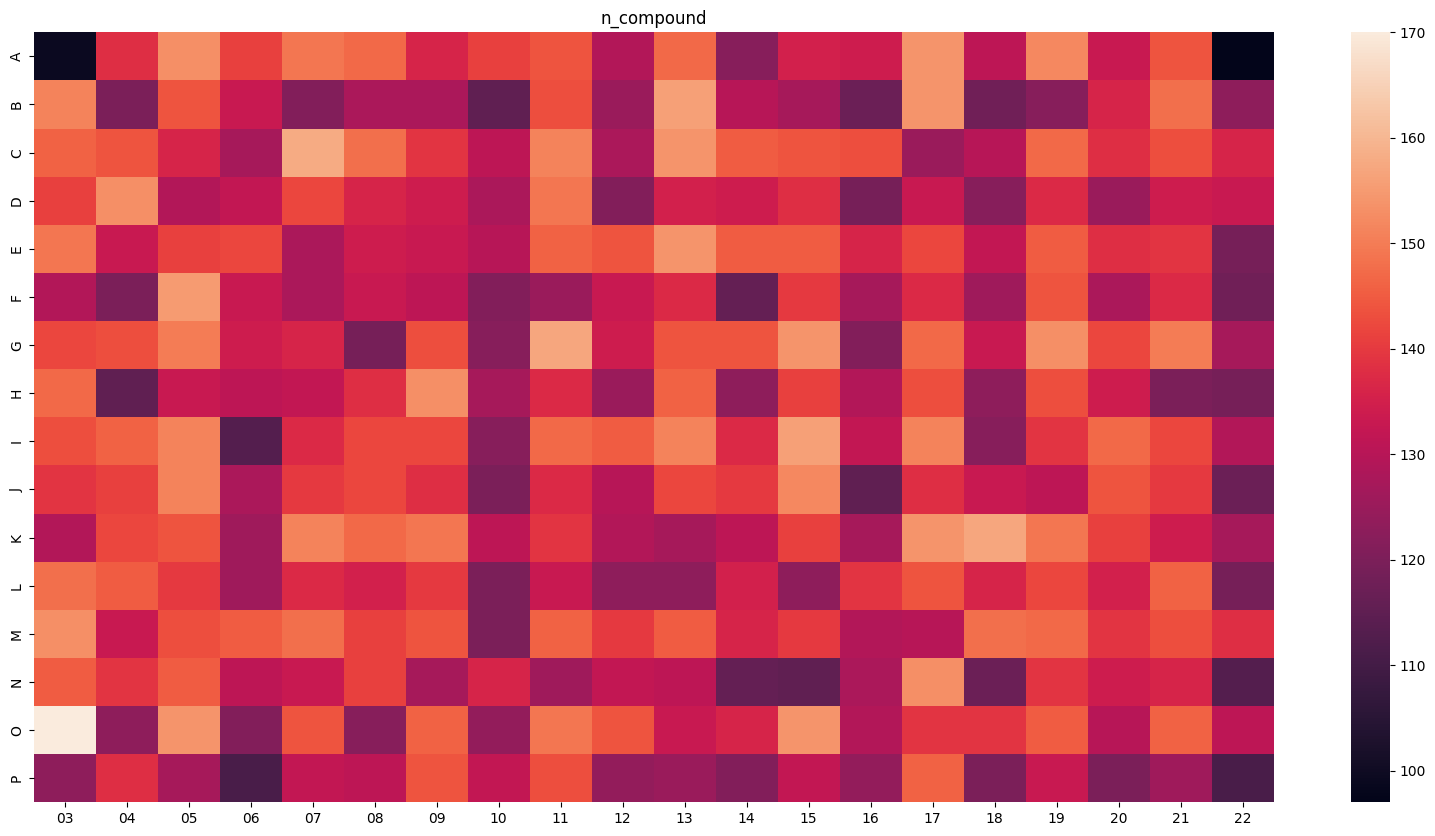

In [1210]:
subset4 = filter_merge_table.join(test4.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner")
subset4 = Apply_threshold(subset4)

show_distribution(subset4)

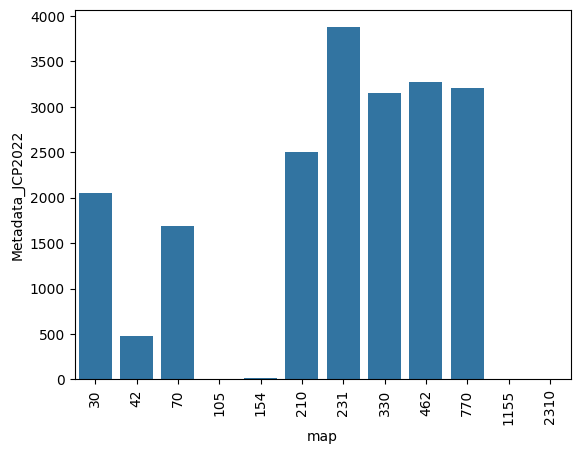

In [1211]:
test4 = Prepare_table(subset4)
show_distribution_pair(test4)

In [1217]:
subset4.shape

(76024, 15)

In [1218]:
subset4.select(pl.all().n_unique())

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,moa,Micro_id
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
20267,20267,20267,5,868,320,59,1,3,2,2,2,3,5,4


## Different test but not relevant 

#### Balancing the source 2, 3, and 8 by tackling the following group:
* 330 for source 2 and 3  with equal probability of removal.
* 462 for source 2, 3 and 8 with equal probability of removal.
* 770 for source 2 and 8  with equal probability of removal.

In [1197]:
np.random.seed(seed)
mask = np.random.rand(2500) < 1/2
test4_pair = test4.group_by("Metadata_JCP2022").agg(pl.col("map").product())
test5_1 = (test4_pair
 .filter(pl.col("map") == 330)
 .sort(by="Metadata_JCP2022")
 .sample(2500, seed=seed)
 .with_columns(pl.Series(name="Metadata_Source", values=mask))
 .with_columns(
     pl.when(pl.col("Metadata_Source") == True)
     .then(pl.lit("source_2"))
     .otherwise(pl.lit("source_3"))
     .alias("Metadata_Source"))
         .select(pl.col("Metadata_JCP2022","Metadata_Source"))
        )

np.random.seed(seed)
mask = np.random.rand(2500) * 3

test5_2 = (test4_pair
 .filter(pl.col("map") == 462)
 .sort(by="Metadata_JCP2022")
 .sample(2500, seed=seed)
 .with_columns(pl.Series(name="Metadata_Source", values=mask))
 .with_columns(
     pl.when(pl.col("Metadata_Source") < 1)
     .then(pl.lit("source_2"))
     .when(pl.col("Metadata_Source") >= 2)
     .then(pl.lit("source_8"))
     .otherwise(pl.lit("source_3"))
     .alias("Metadata_Source"))
         .select(pl.col("Metadata_JCP2022","Metadata_Source"))
        )

np.random.seed(seed)
mask = np.random.rand(2500) < 1/2

test5_3 = (test4_pair
 .filter(pl.col("map") == 770)
 .sort(by="Metadata_JCP2022")
 .sample(2500, seed=seed)
 .with_columns(pl.Series(name="Metadata_Source", values=mask))
 .with_columns(
     pl.when(pl.col("Metadata_Source") == True)
     .then(pl.lit("source_2"))
     .otherwise(pl.lit("source_8"))
     .alias("Metadata_Source"))
         .select(pl.col("Metadata_JCP2022","Metadata_Source"))
        )

test5 = (test5_1.join(test5_2,
                   on=["Metadata_JCP2022","Metadata_Source"],
                   how="outer")
         .join(test5_3,
               on=["Metadata_JCP2022","Metadata_Source"],
               how="outer"))

test5 = test4.join(test5_1,
                   on=["Metadata_JCP2022","Metadata_Source"],
                   how="anti")

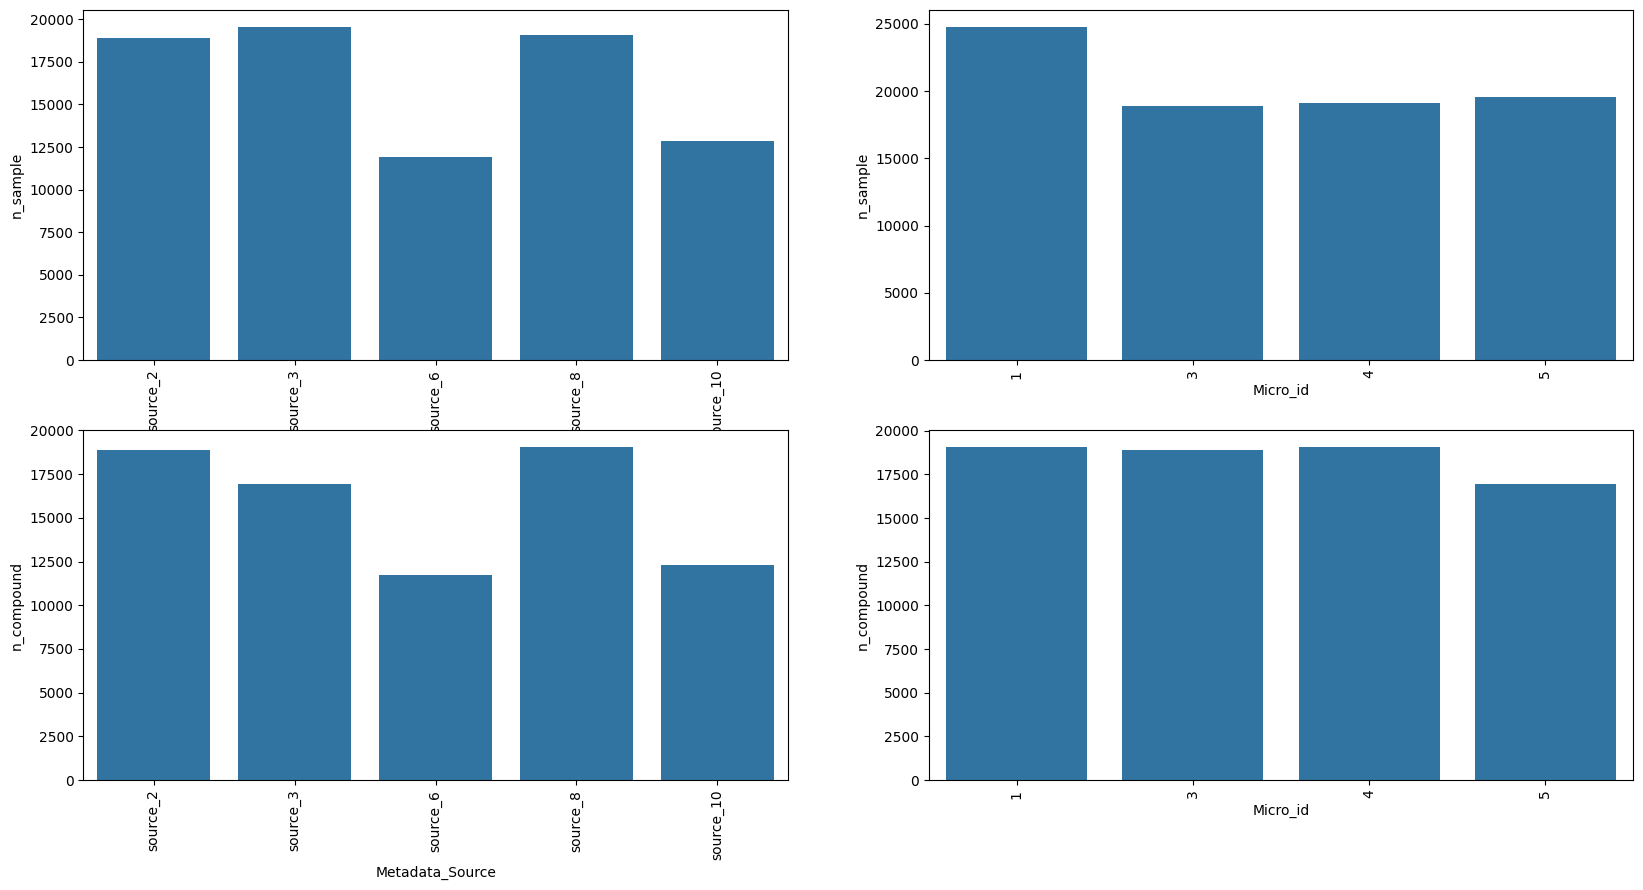

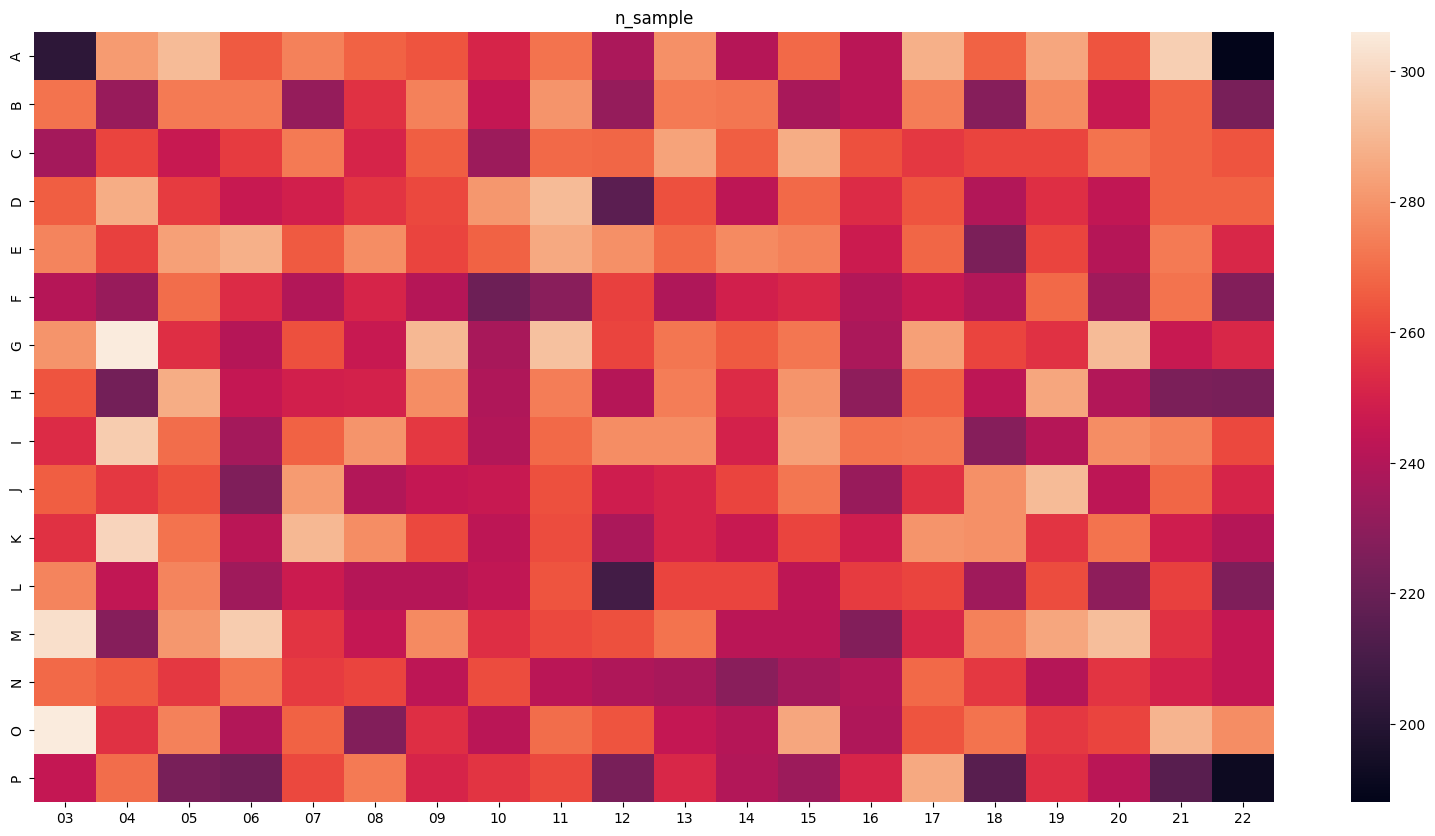

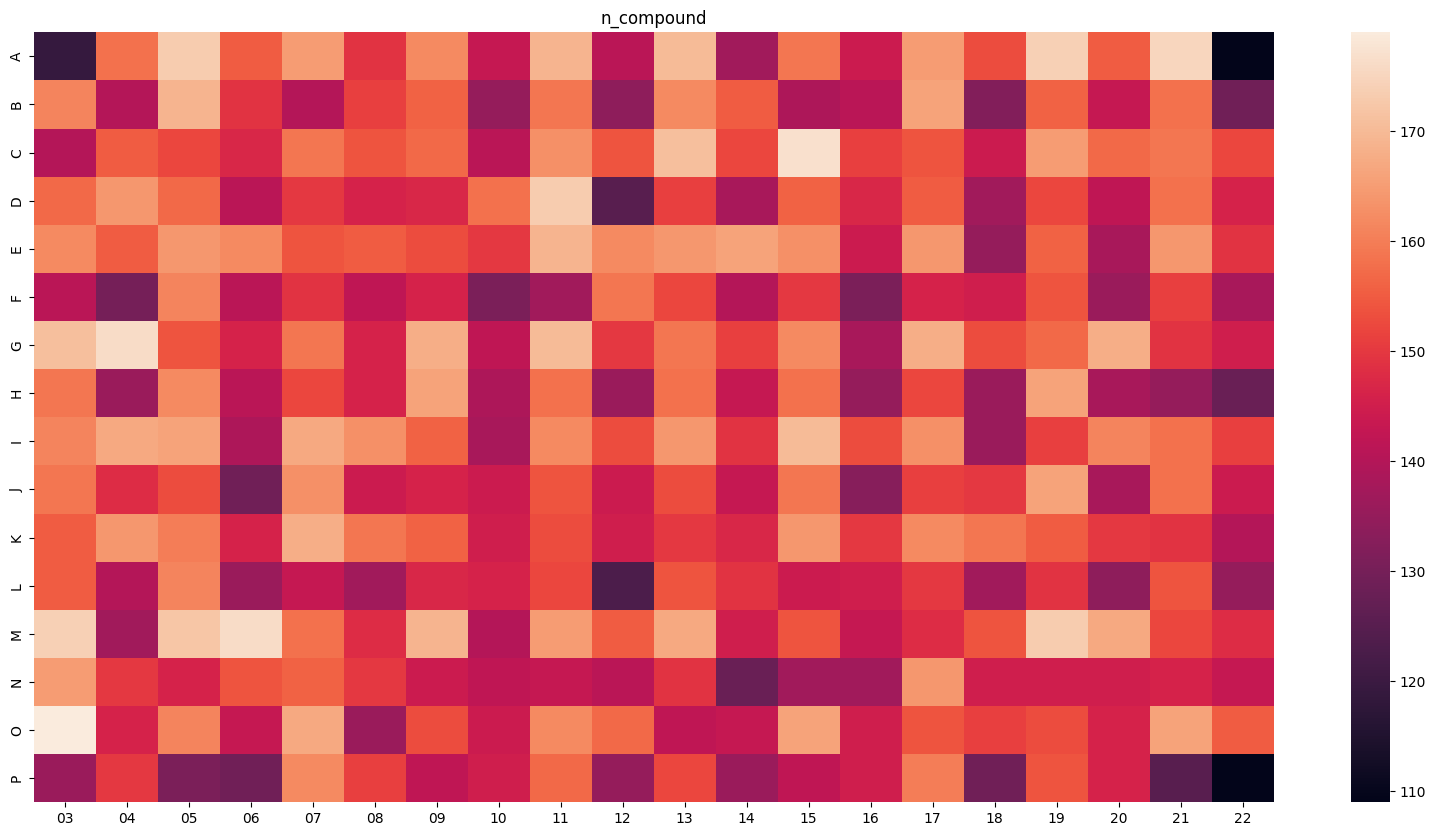

In [1195]:
subset5 = filter_merge_table.join(test5.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner")
subset5 = Apply_threshold(subset5)

show_distribution(subset5)

#### Test

In [1042]:
(subset2.group_by("Metadata_Source")
 .agg(
     pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
     pl.col("Metadata_JCP2022").count().alias("n_sample"))
 .sort(by="Metadata_Source"))

Metadata_Source,n_compound,n_sample
str,u32,u32
"""source_10""",21849,22669
"""source_2""",25892,25934
"""source_3""",25717,28320
"""source_6""",14344,14535
"""source_8""",25221,25226


In [1043]:
(subset2.group_by(["Micro_id"])
 .agg(
     pl.col("Metadata_JCP2022").n_unique().alias("n_compound"),
     pl.col("Metadata_JCP2022").count().alias("n_sample"))
 .sort(by="Micro_id"))

Micro_id,n_compound,n_sample
u32,u32,u32
1,25158,37204
3,25892,25934
4,25221,25226
5,25717,28320


In [1044]:
np.random.seed(seed)
mask = np.random.rand(7000) < 1/4

test3 = (test2.group_by("Metadata_JCP2022").agg(pl.col("map").product())
 .filter((pl.col("map").is_in([330, 770])))
 .sort(by="Metadata_JCP2022")
 .sample(7000, seed=seed)
 .with_columns(pl.Series(name="Metadata_Source", values=mask))
 .with_columns(
     pl.when(pl.col("Metadata_Source") == True)
     .then(pl.lit("source_6"))
     .otherwise(pl.lit("source_10"))
     .alias("Metadata_Source"))
         .select(pl.col("Metadata_JCP2022","Metadata_Source"))
        )
test3 = test2.join(test3,
                   on=["Metadata_JCP2022","Metadata_Source"],
                   how="anti")

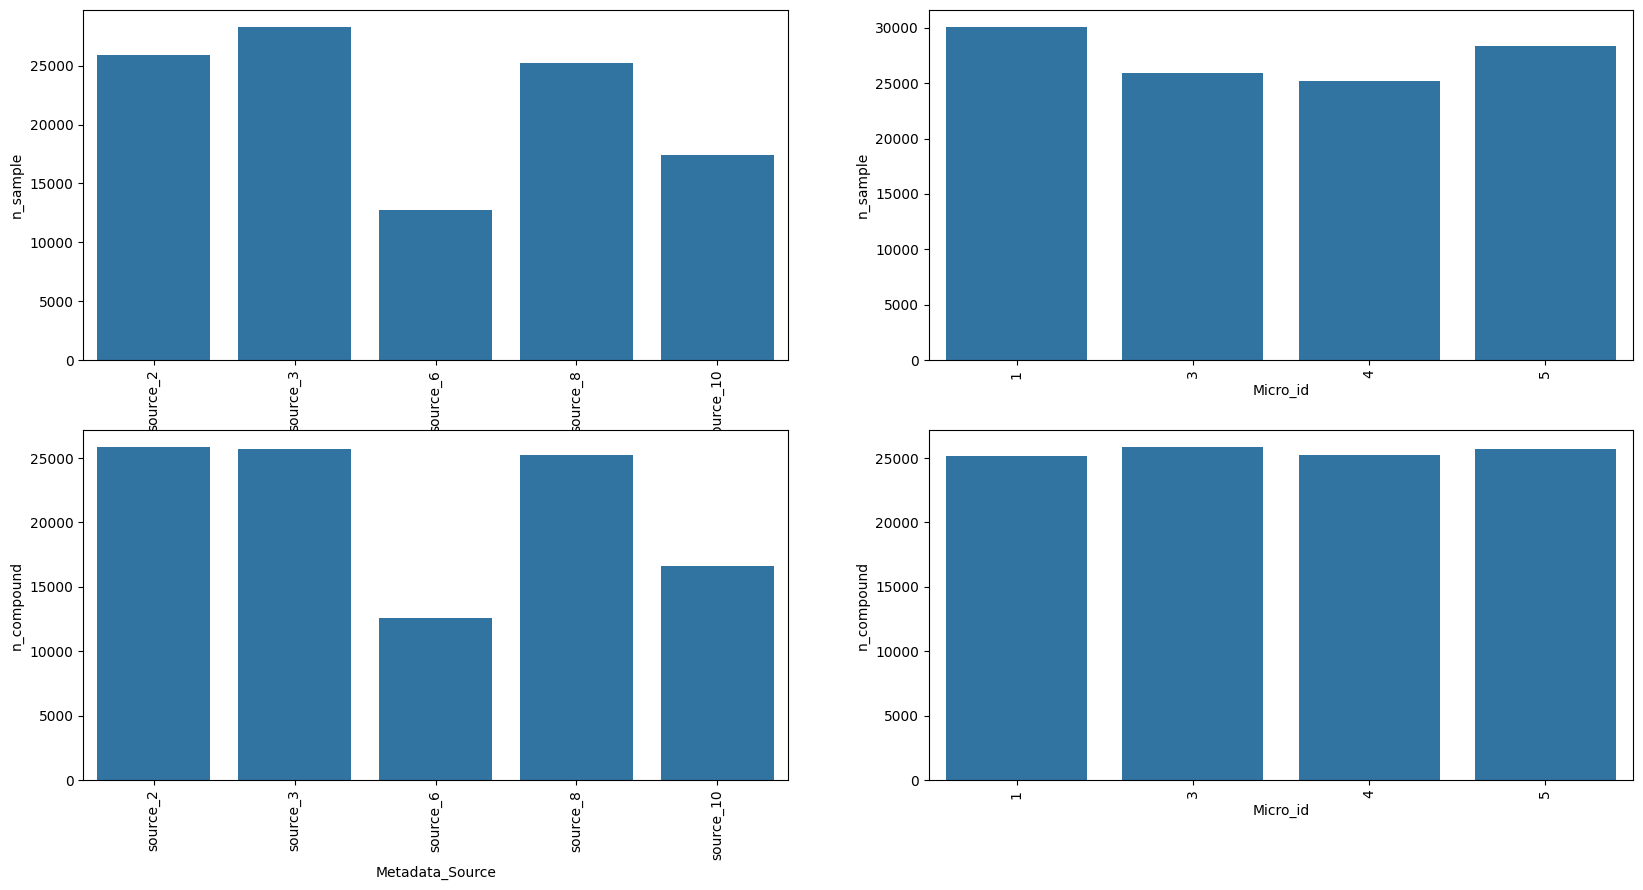

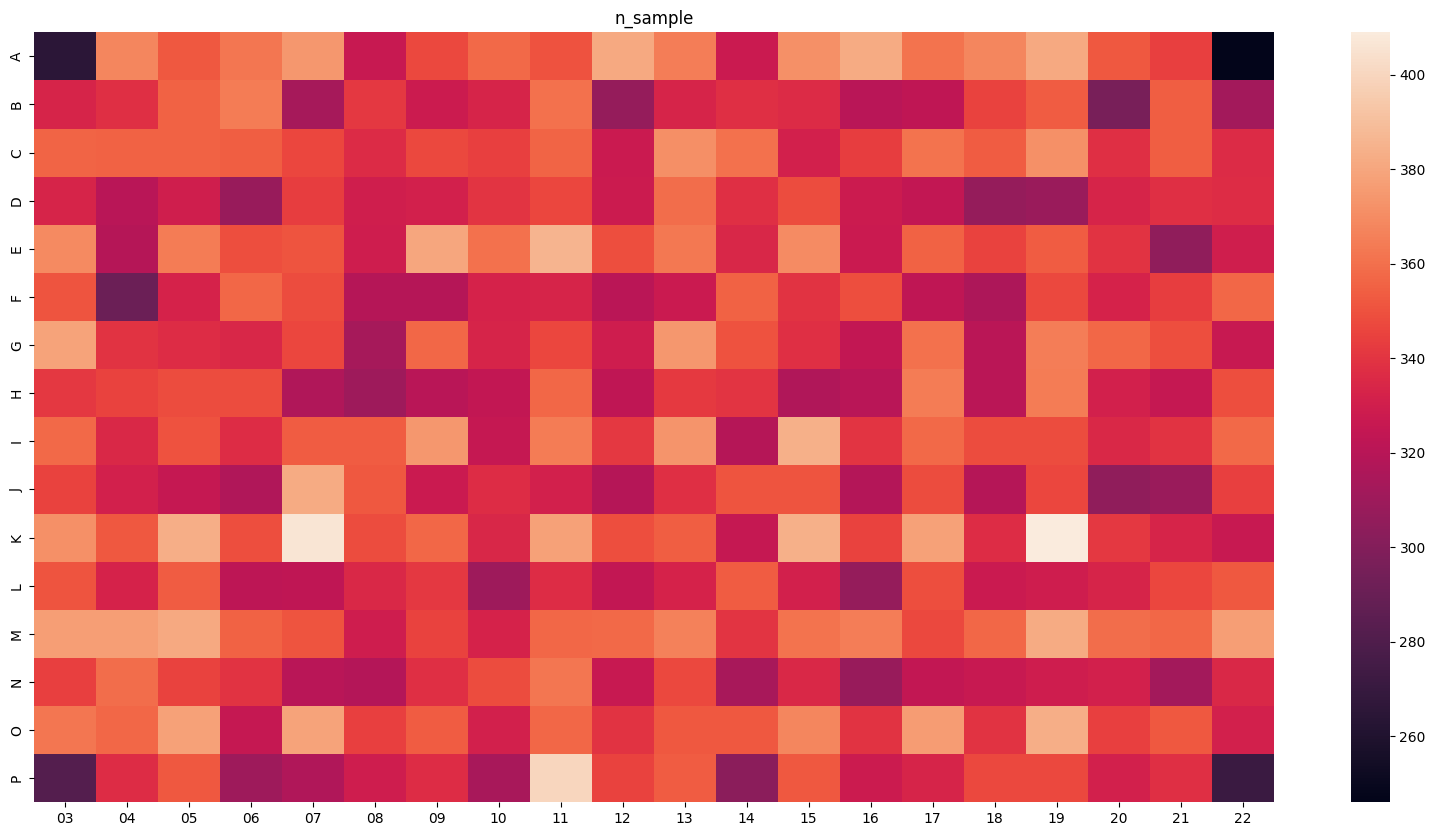

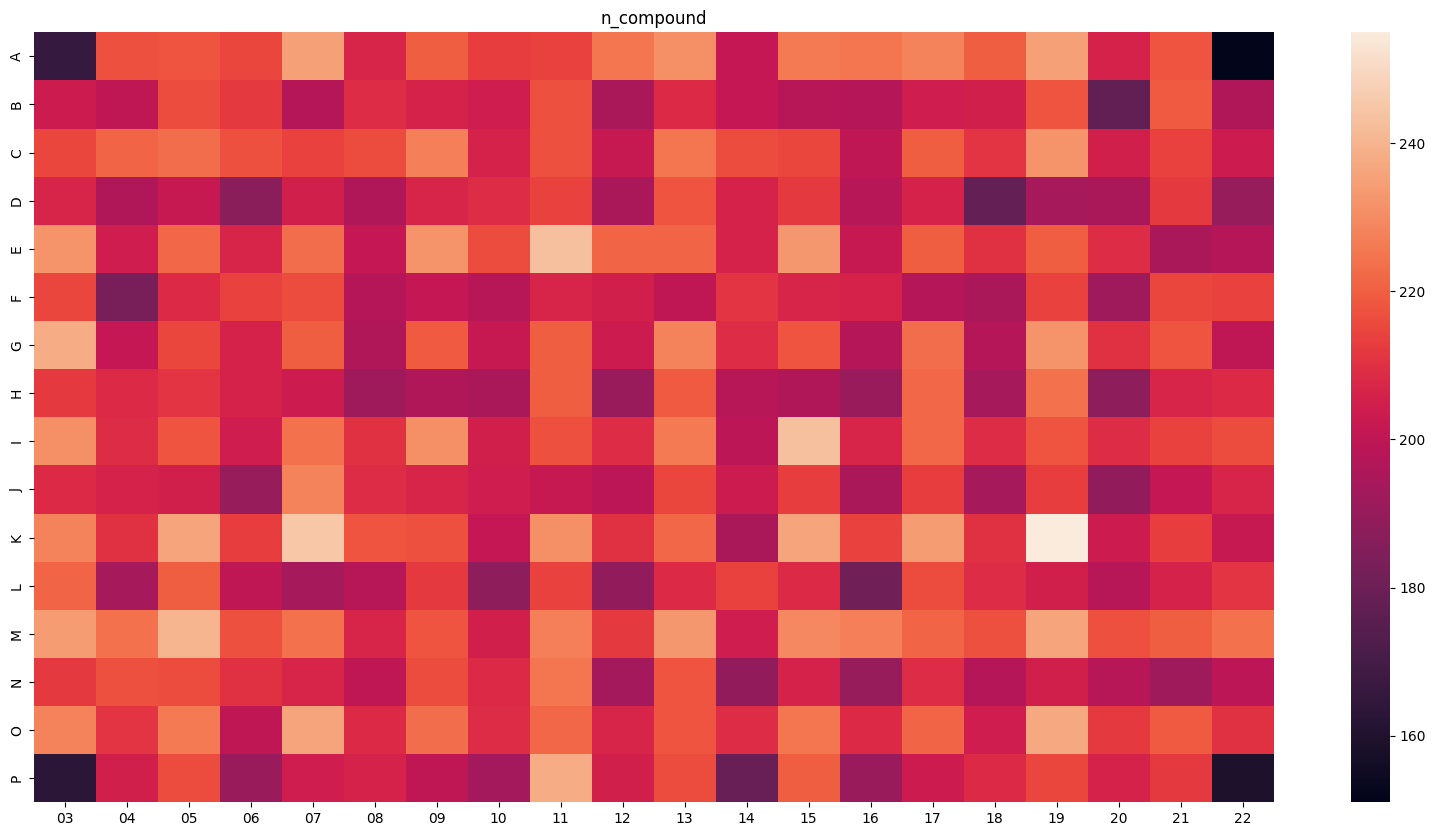

In [1045]:
subset3 = filter_merge_table.join(test3.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner")
subset3 = Apply_threshold(subset3)

show_distribution(subset3)

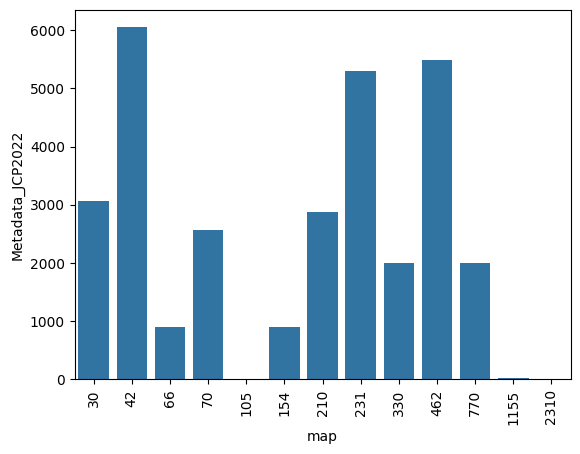

In [1046]:
test3 = Prepare_table(subset3)
show_distribution_pair(test3)

In [1047]:
subset3

Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,moa,Micro_id
str,str,str,str,str,str,str,str,str,str,str,f64,str,str,u32
"""JCP2022_056163…","""MSBCRWMJOBIJPQ…","""InChI=1S/C21H2…","""source_10""","""Dest210531-152…","""A03""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_054175…","""MHIYTIMSMNXVQH…","""InChI=1S/C21H2…","""source_10""","""Dest210531-152…","""A04""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_105072…","""XOZALCXPBGJTDN…","""InChI=1S/C30H4…","""source_10""","""Dest210531-152…","""A08""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_039565…","""JGBVZBMGAVXILJ…","""InChI=1S/C17H1…","""source_10""","""Dest210531-152…","""A10""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_108954…","""YJXZIVYUEWLXIY…","""InChI=1S/C23H2…","""source_10""","""Dest210531-152…","""A11""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_037012…","""IRVUMFSKIKORTI…","""InChI=1S/C26H2…","""source_10""","""Dest210531-152…","""A12""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_078410…","""RHKFRTOCDHMGLJ…","""InChI=1S/C18H2…","""source_10""","""Dest210531-152…","""A14""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_095716…","""VQZFFWCQZXZQMZ…","""InChI=1S/C18H2…","""source_10""","""Dest210531-152…","""A15""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1
"""JCP2022_054082…","""MGVIEQVJONXBSX…","""InChI=1S/C28H4…","""source_10""","""Dest210531-152…","""A16""","""2021_05_31_U2O…","""COMPOUND""","""CV8000""","""Confocal""","""Laser""",0.75,"""A""",null,1


In [1048]:
(subset3.filter(pl.col("Metadata_Source") == "source_3")
 .group_by("Metadata_JCP2022")
 .agg(pl.col("Metadata_InChIKey").count().alias("n_rep"),
      pl.col("Metadata_Well").n_unique().alias("n_well"),
      pl.col("Metadata_Plate").n_unique().alias("n_plate"))
 .filter((pl.col("n_rep") > 1) & (pl.col("n_well") == 1)))#.select("Metadata_JCP2022")

Metadata_JCP2022,n_rep,n_well,n_plate
str,u32,u32,u32
"""JCP2022_054636…",2,1,2
"""JCP2022_031701…",2,1,2
"""JCP2022_026600…",2,1,2
"""JCP2022_016269…",2,1,2
"""JCP2022_018101…",2,1,2
"""JCP2022_114497…",2,1,2
"""JCP2022_076225…",2,1,2
"""JCP2022_047220…",2,1,2
"""JCP2022_001141…",2,1,2


In [994]:
subset3.select(pl.col("Metadata_JCP2022").n_unique())

Metadata_JCP2022
u32
31226


#### Now Let's down sample for the source 2, 3, 7 all together.
The ideal candidate is to remove compounds directly from the group 42 (as 42=2x3x7)

In [857]:
test3 = test2.join(test2.filter(pl.col("map") == 3).sample(7000, seed=seed),
          on=["Metadata_JCP2022", "Metadata_Source", "map"],
          how="anti")

test3 = test3.join(test3.filter(pl.col("map") == 7).sample(5000, seed=seed),
          on=["Metadata_JCP2022", "Metadata_Source", "map"],
          how="anti")

test3 = test3.join(test3.filter(pl.col("map") == 11).sample(5000, seed=seed),
          on=["Metadata_JCP2022", "Metadata_Source", "map"],
          how="anti")

test3 = test3.join(((test3.group_by("Metadata_JCP2022")
 .agg(pl.col("Metadata_Source").n_unique())).filter(pl.col("Metadata_Source") < 3)
            .select("Metadata_JCP2022")),
           on="Metadata_JCP2022",
           how="anti")


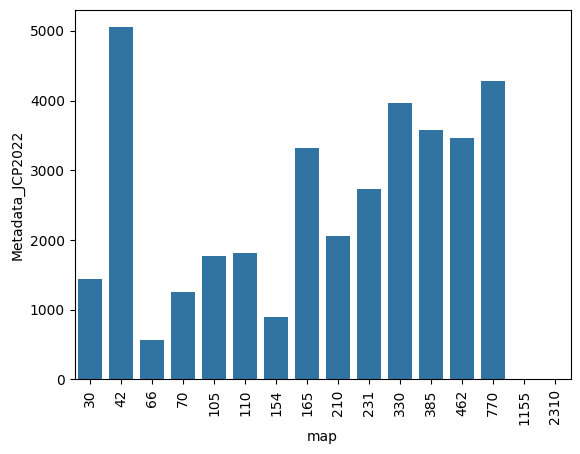

In [858]:
sns.barplot(test3.group_by("Metadata_JCP2022").agg(pl.col("map").product())
 .group_by("map").agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="map"),
           x="map",
           y="Metadata_JCP2022")
plt.gca().tick_params(axis='x', rotation=90)

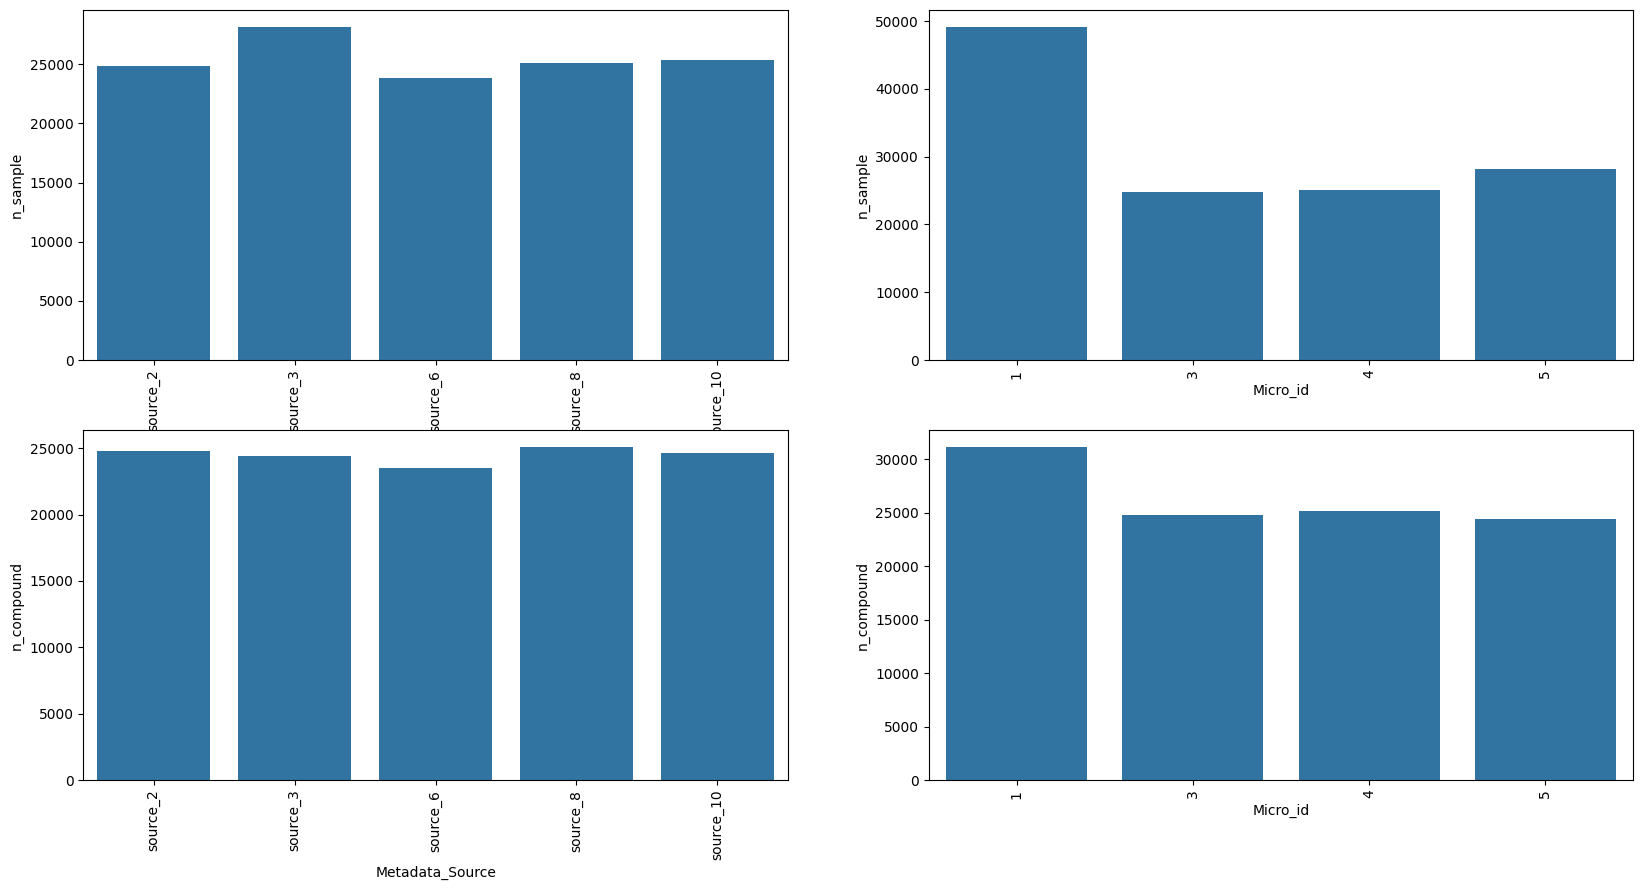

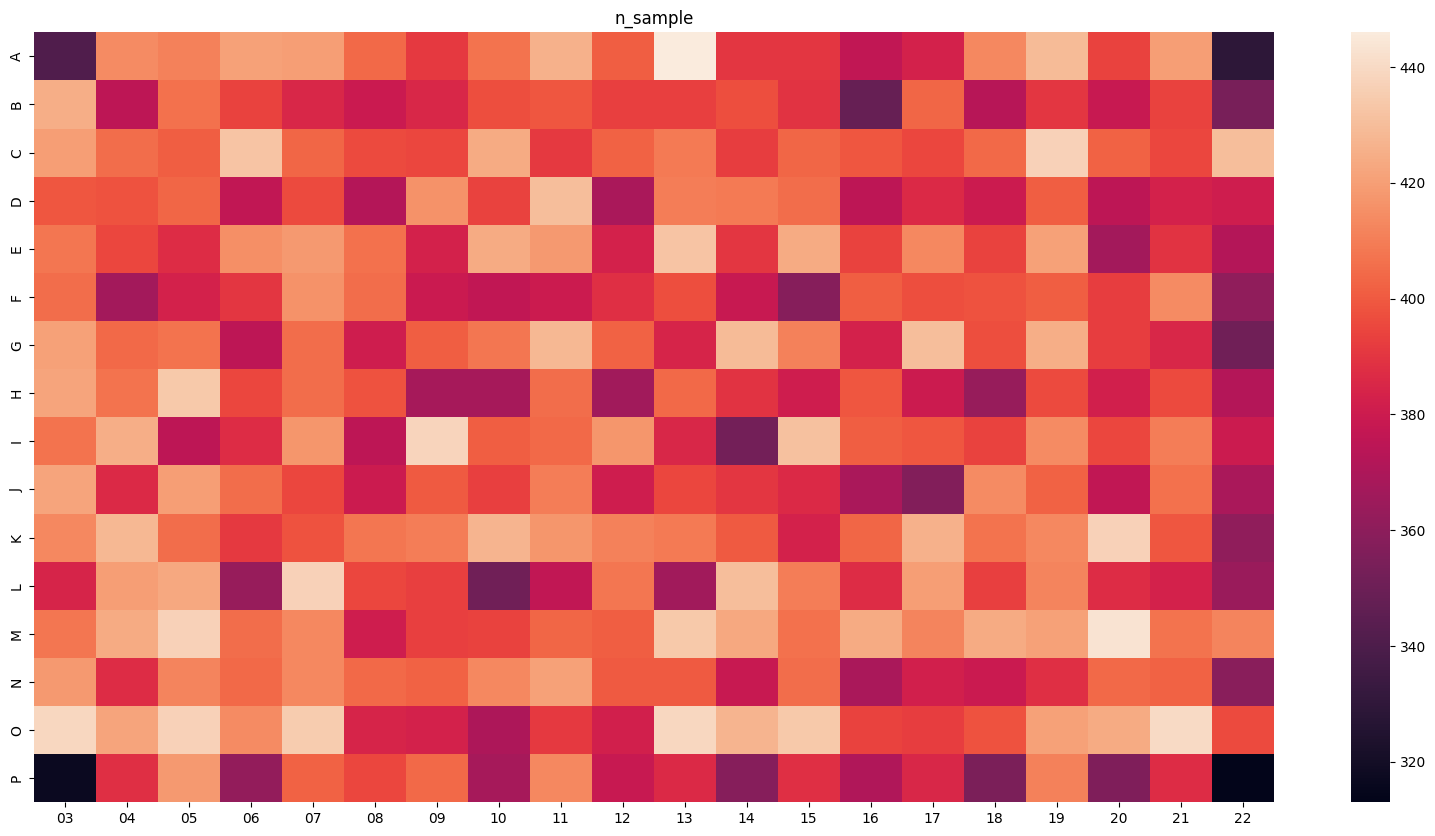

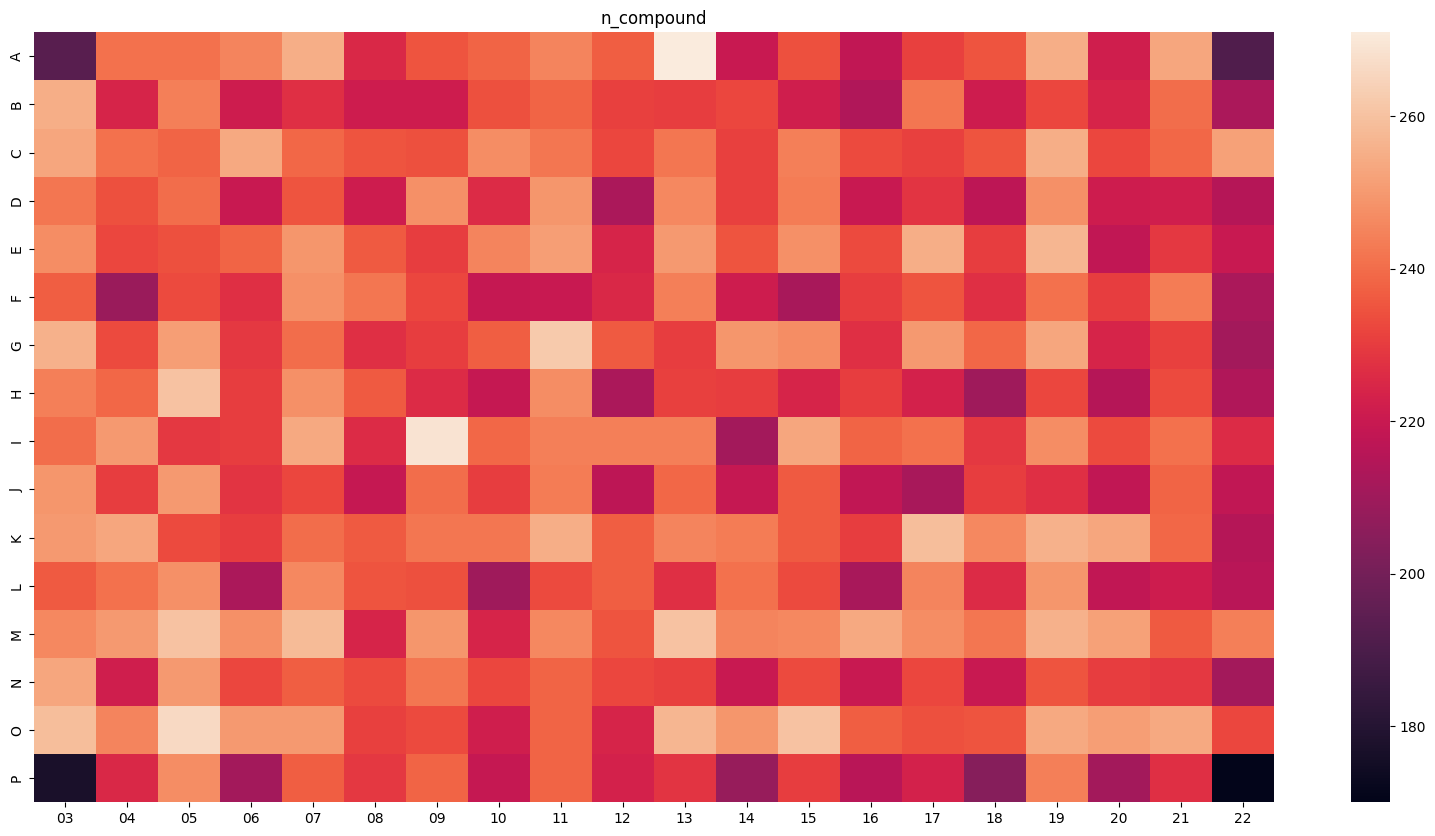

In [859]:
show_distribution(filter_merge_table.join(test3.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner"))

Here the number of compound in micro config 1 is overrepresented. That's because there is too many pair with source 6 and source 10 in it. As we don't necessarily remove compounds for the sake of removing them, let's remove sample of compounds which have been tested in 4 different sources with the source 6 xor 10 in it. 
This gives 2 pair of sources possible:

* source 2 / 3 / 5 / 7 -> map to 2 / 5 / 7 / 11 -> 210
* source 2 / 3 / 7 / 11 -> map to 3 / 5 / 7 / 11 -> 462
  

In [866]:
test4 = (test3.group_by("Metadata_JCP2022").agg(pl.col("map").product())
 .filter((pl.col("map").is_in([210, 462])))
 .sort(by="Metadata_JCP2022")
 .sample(3000, seed=seed)
 .with_columns(
     pl.when(pl.col("map") == 462)
     .then(pl.lit("source_10"))
     .otherwise(pl.lit("source_6"))
     .alias("Metadata_Source"))
         .select(pl.col("Metadata_JCP2022","Metadata_Source"))
        )
test4 = test3.join(test4,
                   on=["Metadata_JCP2022","Metadata_Source"],
                   how="anti")

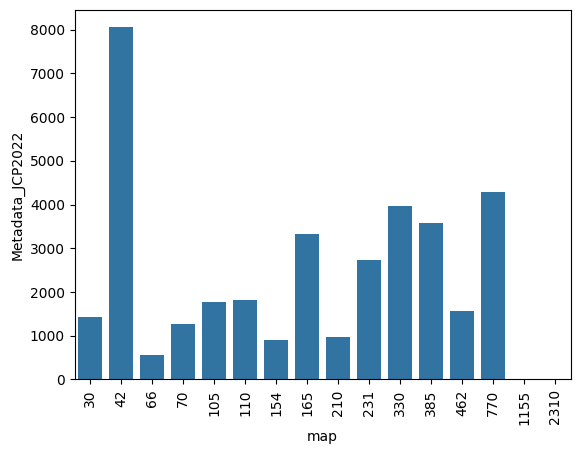

In [867]:
sns.barplot(test4.group_by("Metadata_JCP2022").agg(pl.col("map").product())
 .group_by("map").agg(pl.col("Metadata_JCP2022").n_unique()).sort(by="map"),
           x="map",
           y="Metadata_JCP2022")
plt.gca().tick_params(axis='x', rotation=90)

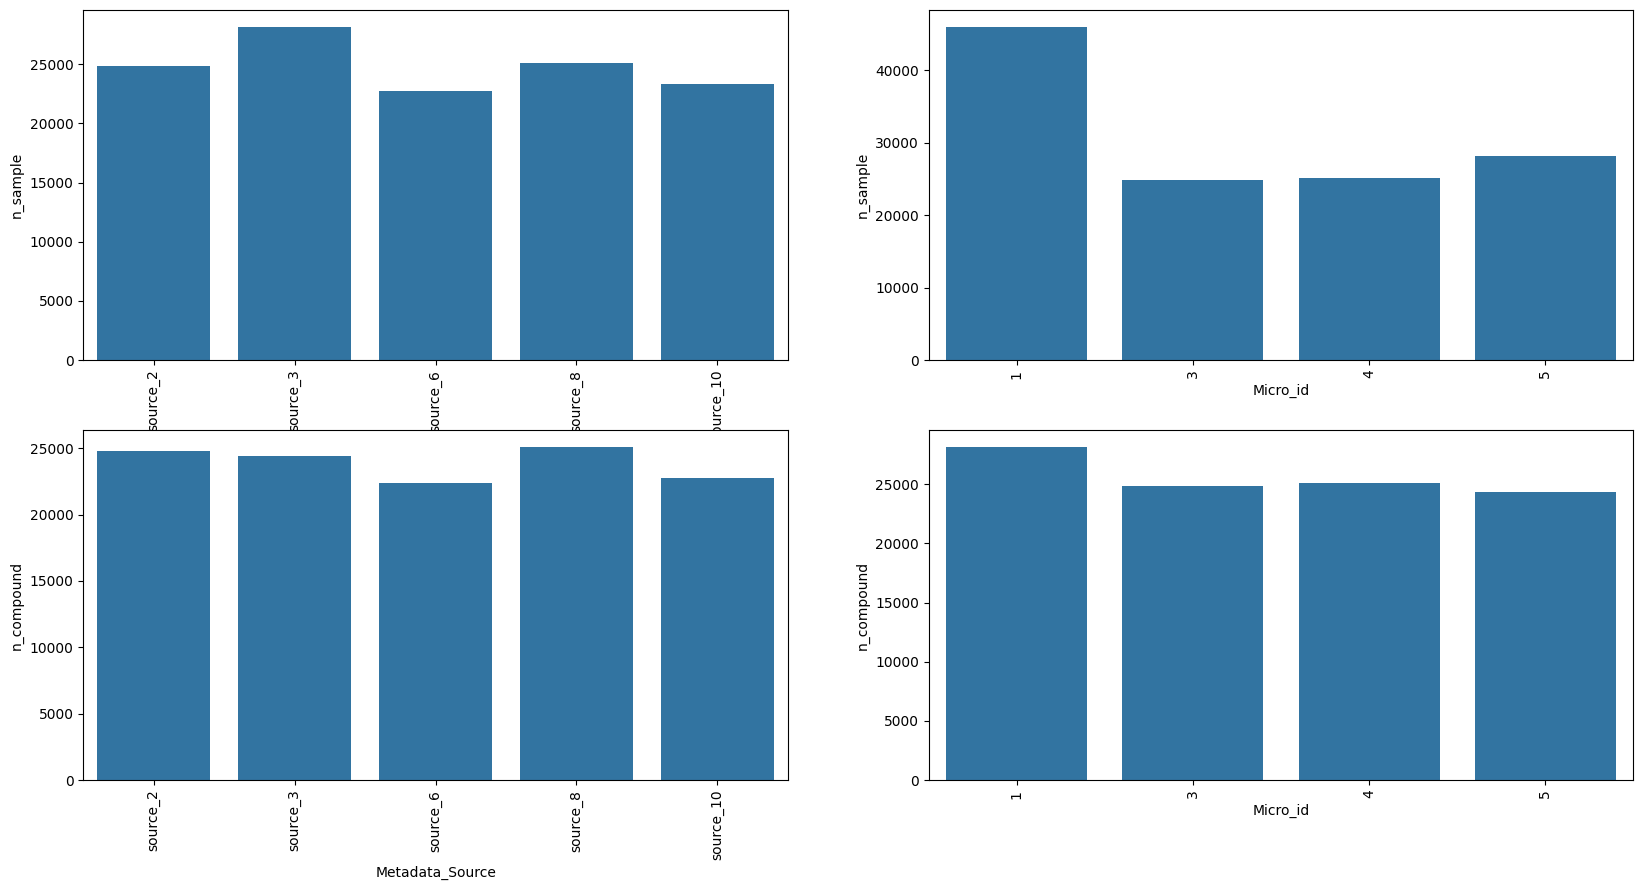

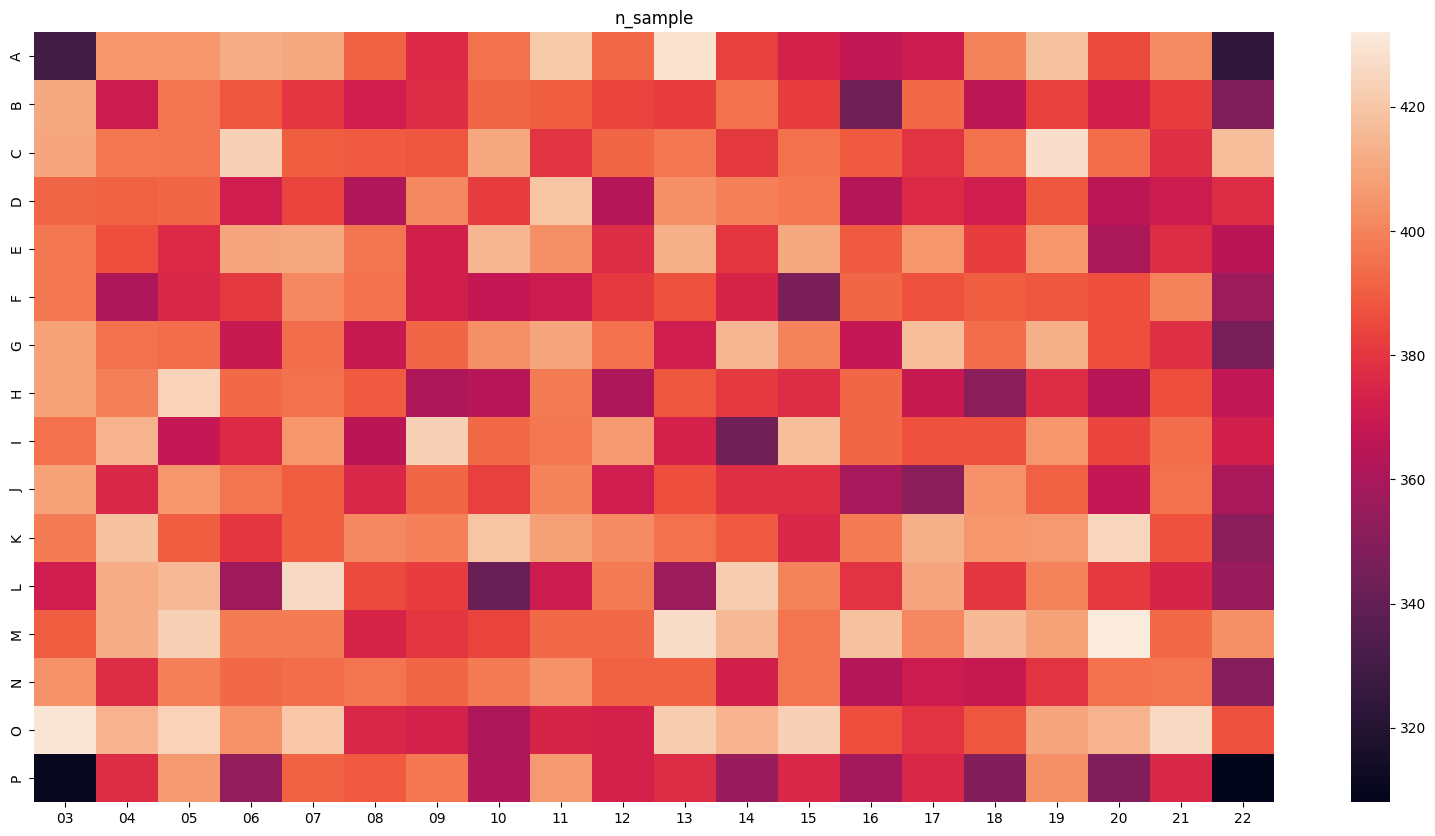

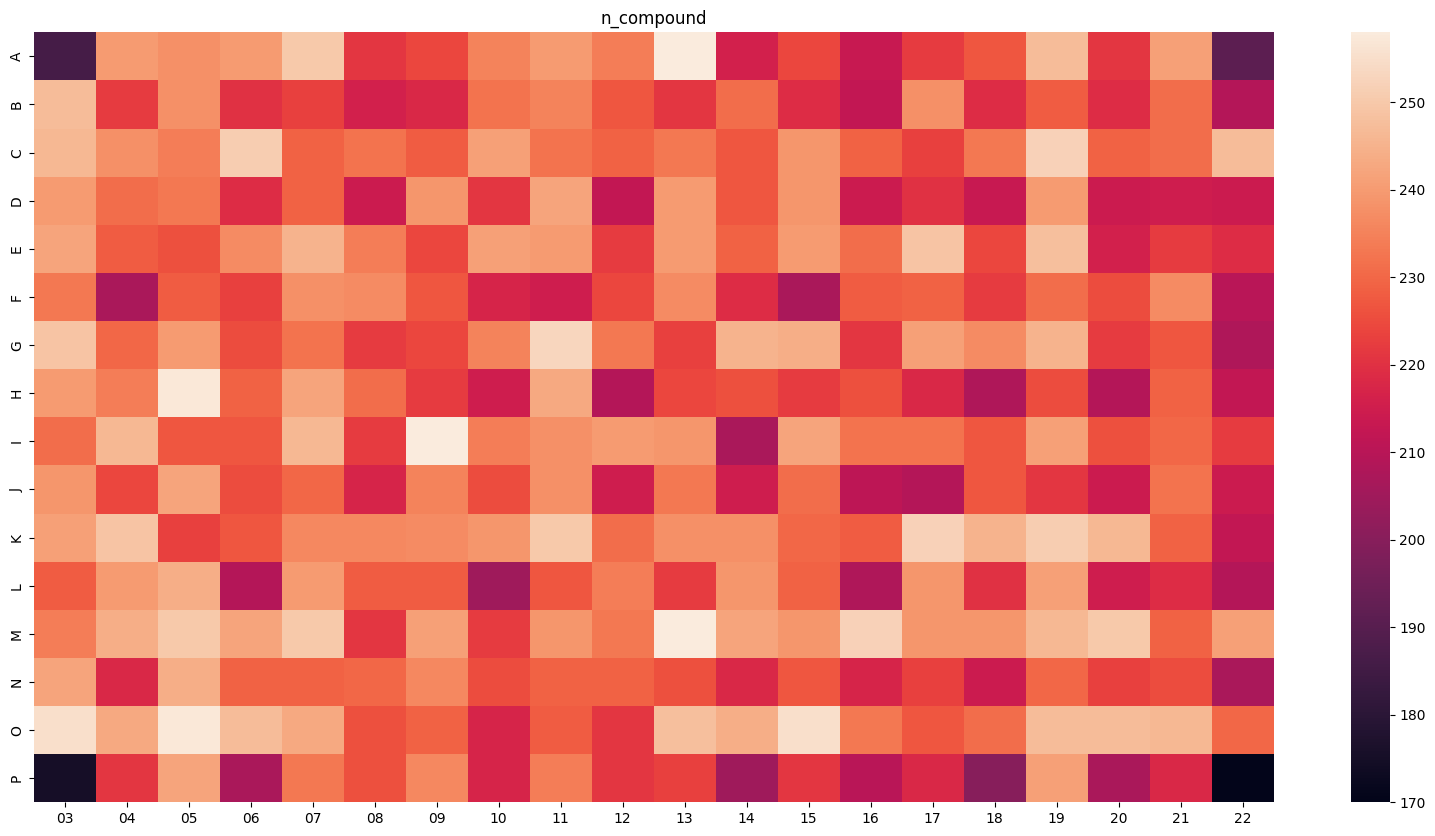

In [868]:
show_distribution(filter_merge_table.join(test4.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner"))

In [869]:
subset = filter_merge_table.join(test4.select(pl.col("Metadata_JCP2022", "Metadata_Source")),
                        on=["Metadata_JCP2022", "Metadata_Source"],
                        how="inner")

### e) Coherence of Sample among source and micro config. 

In [870]:
subset = Apply_threshold(subset)

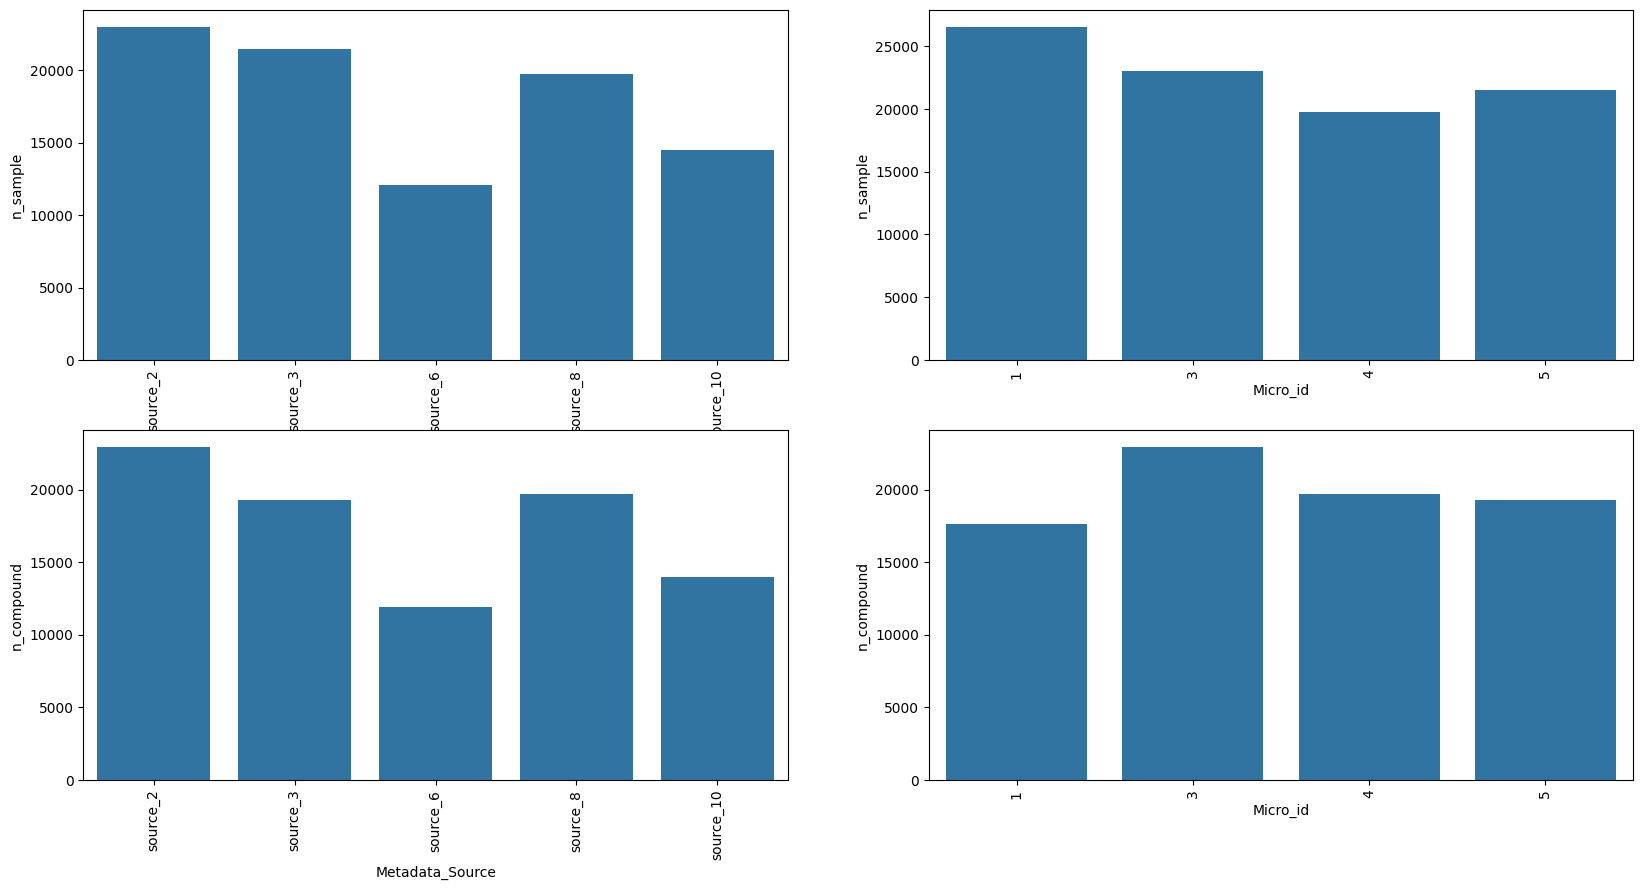

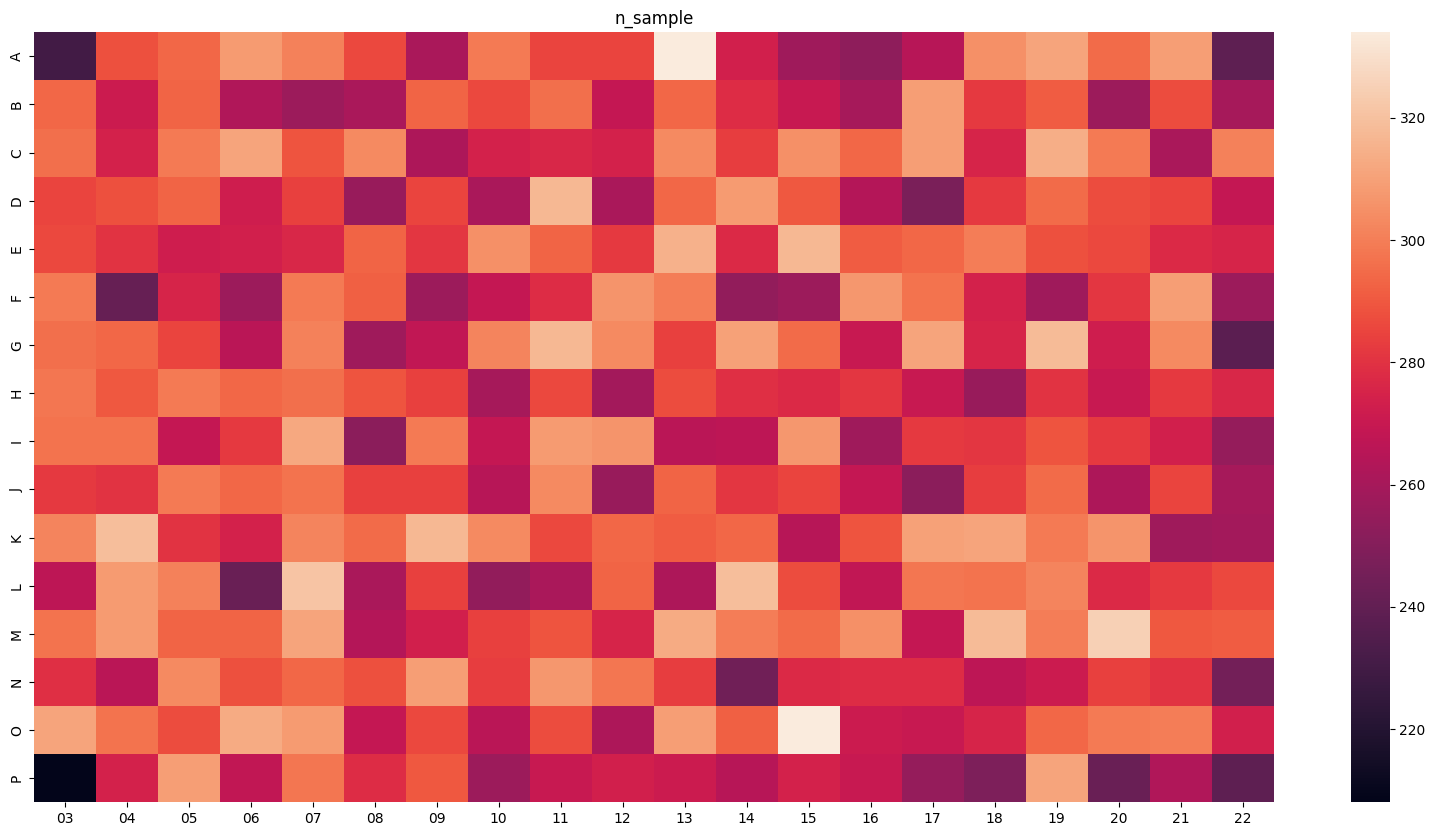

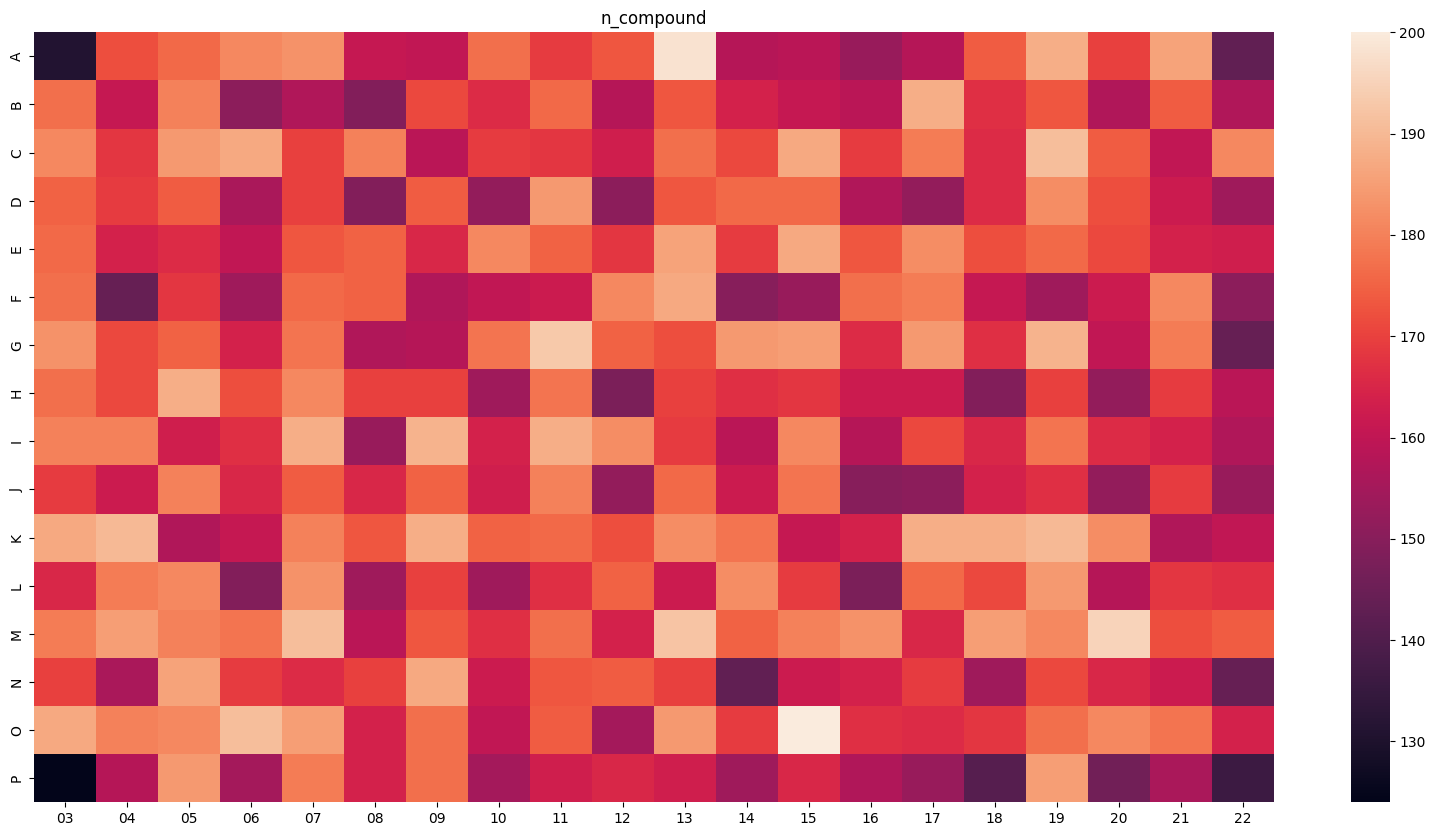

In [871]:
show_distribution(subset)